In [1]:
using HDF5
using JSON
using Plots, LinearAlgebra, Statistics, Random, StatsBase, Compat, Distributions

data = Dict()

filenames = ["mcmc_electron.hdf5"];


# d = Uniform(0, 35)
# data_samples = Array{Float64, 1}()
# counter = 0
# while counter < 10000
#     x = rand(d)
#     if abs(x) <= 30.5
#         counter += 1
#         push!(data_samples, convert(Int, round(x)))
#     end
# end
# u=unique(data_samples)
# thetas=Dict([(i,count(x->x==i,data_samples)) for i in u])

theta_distr = []

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")

    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [elem.data[1] for elem in read(m)["deposit"]]
        energy_value = j["values"]["macros"]["energy"]
        theta = j["values"]["macros"]["theta"]
        if theta == 0
            if !haskey(data, energy_value)
                data[energy_value] = []
            end
            append!(data[energy_value], data_array)
        end
    end

    close(ligo)
end

# for energy in keys(data)
#     Random.shuffle!(data[energy])
# end

mcmc_electron.hdf5


In [12]:
length(sort(collect(keys(data))))

30

In [2]:
include("../../statreg_materials/StatReg.jl/src/StatReg.jl")
using .StatReg


plotly()
gr(size=(500,500), html_output_format=:png)

GLOBAL_RNG = 123
Random.seed!(123);

In [3]:
using Memoize
@memoize function K(E, y)
    return mean([elem[y] for elem in data[E]])
end

energy = sort(collect(keys(data)));

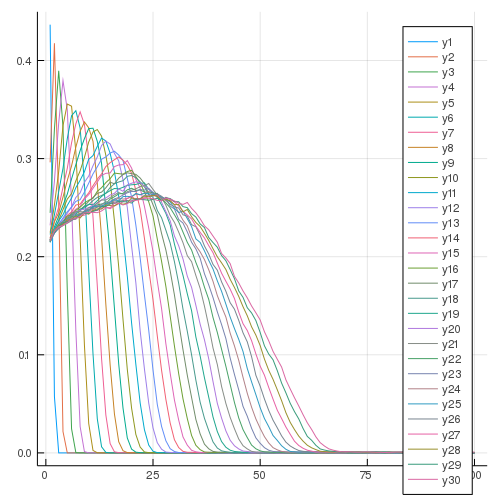

In [45]:
p = plot()
for e in energy
    p = plot!(collect(range(1, stop=100)), [K(e, y_) for y_ in collect(range(1, stop=100))])
end
display(p)

In [24]:
function create_spectrum(n_energy, energy)
    arr = []
#     for (key, value) in data
#         n = n_energy[floor(Int, key*10)]
#         data_arr = sample(value, n)
#         append!(arr, data_arr)
#     end
    for (n, i) in zip(n_energy, energy)
        value = data[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum (generic function with 2 methods)

In [138]:
# function real_spectrum(E)
# #     C = 3.26 * 10^7
# #     ga = 0.87
# #     gb = 4.68
# #     E0 = 12.8
# #     dt = 1.44 * 10^5
#     C = 1.35 * 10^9
#     ga = 1.04
#     gb = 3.52
#     E0 = 27.4
#     dt = 1.19 * 10^5
    
#     if E < (gb - ga) * E0
#         return C * E^(-ga) * exp(- E / E0) / dt * E * 27
#     else
#         return C * E^(-gb) * ((gb-ga) * E0)^(gb-ga) * exp(ga-gb) / dt * E * 27
#     end
# end

function real_spectrum(E)
#     Ca = 6.58 * 10^8
#     Cb = 1.46 * 10^8
#     ga = 1.90
#     gb = 4.27
#     dt = 1.19 * 10^5
#     E0 = 0.5
    Ca = 1.08 * 10^7
    Cb = 1.67 * 10^7
    ga = 1.50
    gb = 3.98
    dt = 2.27 * 10^5
    E0 = 1.32
    if E < E0
        return Ca * E^(-ga) / dt
    else
        return Cb * E^(-gb) / dt
    end
end

# p = collect(range(1, stop=150));
# plot(p, real_spectrum.(p), xlabel="E, MeV", ylabel="N", title="Spectrum", label="", dpi=400,
#     xtickfontsize=16, ytickfontsize=16, legendfontsize=18, guidefont=font(16), color = :blue, xscale=:log10, yscale=:log10)
# savefig("spectrum_cont.png")

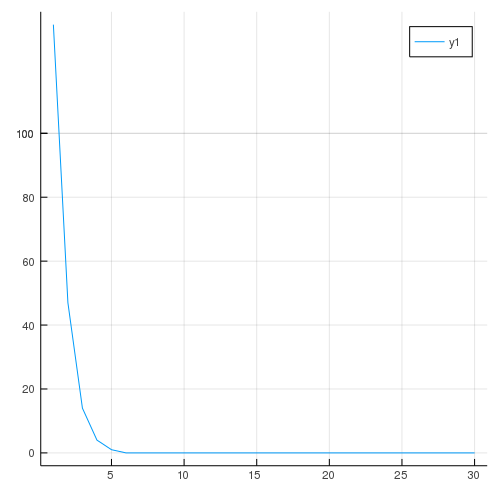

In [139]:
arr_spectrum_real = [floor(Int, real_spectrum(x_)) for x_ in energy]
f_y = create_spectrum(arr_spectrum_real, energy);

plot(arr_spectrum_real)

In [140]:
@memoize function K_cont(E, y)
    if E in energy
        return K(E, y)
    end
    E_max = energy[findfirst(x -> x>=E, energy)]
    E_min = energy[findlast(x -> x<=E, energy)]
#     println(E_max, E_min)
    return (K(E_min, y) * (E_max - E) + K(E_max, y) * (E - E_min)) / (E_max - E_min)
end

K_cont (generic function with 1 method)

In [141]:
# K_E_y = zeros(100, 150)
# for i in range(1, stop=100)
#     for j in range(1, stop=150)
#         K_E_y[i, j] = K(j, i)
#     end
# end

In [142]:
# K_E_y_another = [0.916205 1.83241 2.74862 3.66453 4.58103 5.49669 6.41207 7.32819 8.24431 9.15683 6.85511 5.84505 5.19686 4.71466 4.35359 4.05904 3.81307 3.57844 3.39737 3.2149 3.09029 2.97154 2.82535 2.74154 2.62699 2.54074 2.46889 2.38354 2.30813 2.251 2.18179 2.12179 2.04823 1.99463 1.95836 1.91414 1.87103 1.8285 1.79514 1.76763 1.71227 1.66944 1.63404 1.61892 1.57528 1.55046 1.53064 1.50795 1.4684 1.46372 1.4179 1.40967 1.40145 1.35902 1.33952 1.32491 1.32092 1.282 1.25591 1.23034 1.2314 1.22183 1.21493 1.17387 1.14885 1.14266 1.13708 1.12523 1.12175 1.11054 1.10619 1.09328 1.06684 1.06302 1.05075 1.03917 1.02357 1.00255 1.00961 0.99329 0.977242 0.968543 0.951567 0.934798 0.946144 0.933756 0.925111 0.912715 0.905991 0.886642 0.894738 0.883064 0.877264 0.869638 0.88453 0.87098 0.877661 0.851564 0.847026 0.847658 0.838874 0.828872 0.815784 0.823377 0.810628 0.794677 0.79627 0.800348 0.790209 0.776745 0.787634 0.770489 0.779106 0.771275 0.765036 0.754796 0.757694 0.758962 0.745085 0.732392 0.736022 0.723027 0.730944 0.722016 0.713422 0.709611 0.710687 0.695042 0.70111 0.688789 0.702563 0.678928 0.694067 0.692483 0.682185 0.67708 0.665338 0.676222 0.667971 0.657446 0.659635 0.654612 0.639325 0.642221 0.650045 0.637989 0.633792 0.632129 0.632659 0.631206; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00369053 3.2217 5.14583 6.70173 8.10139 8.48959 6.17036 5.2633 4.66257 4.23942 3.91549 3.64917 3.42809 3.23469 3.07329 2.96065 2.78754 2.68381 2.59784 2.49882 2.41389 2.3418 2.24944 2.19102 2.14352 2.06856 2.01917 1.95469 1.90804 1.8794 1.84955 1.80633 1.76683 1.71106 1.67694 1.63737 1.60578 1.57521 1.53524 1.51787 1.5103 1.47468 1.44623 1.41972 1.39964 1.38137 1.36864 1.33045 1.32404 1.28954 1.30131 1.25563 1.24403 1.24803 1.21279 1.19527 1.1684 1.14942 1.14684 1.12859 1.12319 1.11428 1.11275 1.09884 1.10206 1.07373 1.06704 1.05398 1.03363 1.03491 1.0293 1.0034 0.995598 0.972836 0.969128 0.952139 0.956726 0.928958 0.921869 0.909838 0.891882 0.895855 0.891495 0.883112 0.884563 0.896566 0.878894 0.874959 0.874172 0.859739 0.859633 0.844341 0.84491 0.827374 0.820402 0.821781 0.819707 0.804147 0.805193 0.80535 0.805745 0.778906 0.771544 0.771027 0.765521 0.768365 0.775513 0.760212 0.743913 0.746351 0.746359 0.744883 0.732377 0.743418 0.731394 0.722291 0.731382 0.728858 0.729099 0.709153 0.702823 0.703012 0.686143 0.713063 0.700447 0.685062 0.693901 0.676936 0.670693 0.69276 0.689092 0.6681 0.658675 0.650377 0.648709 0.649781 0.668872 0.646772 0.637567 0.627072 0.643989; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000150856 0.0 0.881896 4.41158 6.46424 8.21942 7.29439 5.63443 4.82783 4.31988 3.93696 3.62077 3.38619 3.18384 3.01479 2.8833 2.75545 2.63321 2.53871 2.42172 2.36492 2.2882 2.21355 2.1592 2.07674 2.00352 1.98847 1.909 1.85687 1.8055 1.80114 1.74275 1.71539 1.65881 1.63078 1.59905 1.55312 1.54008 1.50951 1.4961 1.4663 1.4457 1.40255 1.4023 1.36541 1.32952 1.31733 1.31152 1.27434 1.2672 1.26077 1.23898 1.21442 1.18253 1.16837 1.15451 1.15791 1.13865 1.13246 1.12572 1.10723 1.10674 1.09337 1.08383 1.07194 1.05128 1.04693 1.02735 1.0202 1.00964 0.984454 0.98956 0.958975 0.96158 0.958506 0.932492 0.921999 0.904497 0.906394 0.899327 0.886396 0.899227 0.877899 0.883321 0.879483 0.876233 0.876667 0.868533 0.850407 0.867673 0.831687 0.84108 0.829366 0.828355 0.802588 0.811109 0.808701 0.805244 0.804735 0.793857 0.768492 0.777223 0.759708 0.78902 0.758566 0.749286 0.763344 0.762477 0.733995 0.751258 0.753095 0.734507 0.714607 0.730549 0.724617 0.713116 0.727999 0.718545 0.701274 0.702391 0.688067 0.699107 0.675066 0.693814 0.680712 0.67745 0.689048 0.679409 0.672067 0.677596 0.672119 0.653298 0.665959 0.655243 0.644436 0.64217 0.650498 0.651713; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.07558e-5 0.0 3.07857e-6 0.000343632 3.80164e-5 9.77477e-5 2.43392 5.51677 7.61579 7.99806 5.70464 4.78852 4.21795 3.83834 3.5299 3.29979 3.09483 2.93569 2.79452 2.65879 2.54688 2.44097 2.3519 2.28427 2.20725 2.14389 2.0632 1.99191 1.95787 1.91186 1.85673 1.83391 1.78545 1.7276 1.68499 1.66068 1.61991 1.59147 1.54679 1.51842 1.48781 1.47768 1.45712 1.42921 1.38182 1.37652 1.35678 1.33444 1.30203 1.30656 1.27558 1.25741 1.22553 1.21884 1.18499 1.19269 1.17467 1.17551 1.14249 1.14145 1.11001 1.11001 1.09462 1.0905 1.0739 1.04981 1.05259 1.04346 1.03074 1.02593 0.999817 1.00157 0.97325 0.970088 0.954543 0.960744 0.929795 0.924222 0.914654 0.936153 0.905365 0.893395 0.8961 0.890356 0.869667 0.891328 0.872424 0.871194 0.861273 0.853777 0.852015 0.83498 0.850631 0.83476 0.819738 0.815974 0.821102 0.811418 0.816156 0.799622 0.794446 0.794276 0.772247 0.794867 0.790899 0.757817 0.777692 0.762051 0.739374 0.739622 0.765248 0.744084 0.723324 0.73119 0.730111 0.709701 0.751318 0.718314 0.703987 0.697448 0.701637 0.700336 0.686462 0.686828 0.693093 0.681153 0.679079 0.680502 0.675342 0.69591 0.666121 0.671154 0.662559 0.668023 0.650681 0.649285 0.646313 0.666333; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.10512e-7 0.0 0.000145497 0.0 6.08035e-5 0.000201241 1.38042 5.3196 7.6954 7.30962 5.41073 4.54852 4.02366 3.66493 3.37783 3.1421 2.97778 2.82232 2.65912 2.56255 2.42494 2.36251 2.27541 2.21599 2.11582 2.0688 1.99788 1.95321 1.90055 1.85255 1.81507 1.76801 1.71156 1.6676 1.62706 1.58521 1.5445 1.52461 1.53084 1.47311 1.44985 1.42207 1.41299 1.38977 1.36106 1.33432 1.32369 1.30961 1.2704 1.26204 1.23275 1.22115 1.21436 1.18349 1.16111 1.17876 1.14239 1.14354 1.11867 1.09724 1.10843 1.08979 1.07429 1.06765 1.07631 1.04394 1.02339 1.02667 1.01925 1.00587 0.988904 0.971855 0.958998 0.945208 0.938824 0.922338 0.913865 0.926626 0.908221 0.921083 0.880798 0.874444 0.893046 0.891624 0.892429 0.876288 0.868297 0.860295 0.842721 0.848953 0.848334 0.834119 0.844704 0.831248 0.807506 0.818367 0.814363 0.805784 0.800015 0.789821 0.813406 0.770373 0.786109 0.76342 0.781958 0.738064 0.746595 0.749015 0.756393 0.737918 0.730177 0.742992 0.724544 0.73535 0.718856 0.715053 0.705224 0.711118 0.701697 0.693066 0.695896 0.709951 0.695374 0.681711 0.691099 0.673578 0.668098 0.673888 0.672632 0.667322 0.664286 0.660092 0.663291 0.644544 0.669916; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000129886 0.0 5.88965e-5 0.0 1.09563e-5 0.0 8.5907e-5 4.25274e-5 4.19129e-5 0.0 7.58424e-6 2.32743 5.99721 8.35542 6.11975 4.88517 4.21392 3.76912 3.45689 3.19492 3.0168 2.82899 2.66386 2.54704 2.44703 2.33761 2.25842 2.17835 2.09925 2.06634 1.99429 1.91592 1.87944 1.81538 1.77904 1.73335 1.69564 1.64862 1.60493 1.57432 1.56078 1.51255 1.48937 1.45582 1.44831 1.42893 1.40277 1.378 1.35788 1.34278 1.30253 1.27636 1.27824 1.24777 1.22853 1.21159 1.18934 1.1881 1.15974 1.16354 1.13978 1.12886 1.10937 1.10442 1.0904 1.11001 1.08204 1.05677 1.03575 1.02019 1.02292 1.0149 0.991705 0.976112 0.99289 0.9542 0.954296 0.943662 0.923136 0.933709 0.914609 0.908093 0.896888 0.896483 0.88685 0.883952 0.891465 0.882031 0.873542 0.882985 0.863979 0.858651 0.837403 0.848425 0.86773 0.826862 0.815919 0.823161 0.801437 0.81497 0.792501 0.797111 0.797032 0.769321 0.791769 0.761918 0.765353 0.745724 0.744547 0.744177 0.759309 0.756081 0.752348 0.750803 0.733224 0.73332 0.729778 0.711141 0.710941 0.71112 0.702175 0.702847 0.696829 0.704156 0.701849 0.686795 0.715964 0.672616 0.67781 0.677389 0.672316 0.674549 0.661857 0.658987 0.664374 0.670353 0.665477; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.11088e-6 4.99584e-5 0.0 4.34853e-5 0.0 1.84491e-5 8.70529e-5 7.28526e-5 0.000392894 1.67934e-5 0.0 0.000442368 0.0 0.0 0.0306443 4.2223 7.24826 7.25269 5.20017 4.39349 3.85725 3.48403 3.21851 2.98411 2.8066 2.64883 2.53389 2.4388 2.3569 2.22718 2.15351 2.0866 2.03261 1.95173 1.90094 1.85082 1.81837 1.75764 1.70305 1.66711 1.63664 1.58893 1.55845 1.53334 1.50248 1.47724 1.44608 1.43569 1.41925 1.38876 1.36061 1.33232 1.30472 1.31028 1.26284 1.2394 1.23328 1.20589 1.20389 1.18621 1.18611 1.15254 1.13091 1.12771 1.09862 1.09434 1.0879 1.07601 1.07432 1.05502 1.03391 1.03107 1.01766 1.00793 1.00783 0.976156 0.967336 0.954392 0.93188 0.946182 0.922491 0.928993 0.902662 0.919762 0.897301 0.875521 0.877169 0.884497 0.896265 0.877939 0.863279 0.875951 0.858812 0.839926 0.844607 0.854104 0.831523 0.836346 0.81477 0.806769 0.811648 0.794001 0.80852 0.81625 0.781794 0.786666 0.774221 0.785853 0.760612 0.763707 0.753107 0.764065 0.754021 0.751553 0.743034 0.747766 0.741346 0.726345 0.712382 0.736163 0.71756 0.723596 0.716434 0.702313 0.70896 0.689561 0.701023 0.693727 0.693904 0.675741 0.693983 0.675291 0.681988 0.667884 0.678993 0.667236 0.67096 0.673524; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.7885e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000120508 0.0 8.10073e-6 0.000120326 5.39755e-5 0.000237211 0.000101236 0.0 0.000341392 0.0 0.0 0.000406177 4.76843e-5 3.44481e-5 2.27784 6.28386 8.12567 5.44511 4.4578 3.90392 3.50302 3.21145 2.98056 2.78483 2.63529 2.50438 2.40308 2.29574 2.20507 2.1507 2.05013 2.01075 1.93833 1.88655 1.82924 1.77034 1.73752 1.70078 1.64897 1.6149 1.58195 1.54994 1.51691 1.49032 1.47813 1.43334 1.41442 1.38177 1.36296 1.3555 1.34688 1.30565 1.27531 1.24184 1.22471 1.22547 1.20872 1.18321 1.15681 1.15247 1.12718 1.12281 1.12098 1.11083 1.0974 1.08593 1.09712 1.05123 1.05586 1.02839 1.0407 0.998167 1.01224 0.978594 0.9873 0.953695 0.96313 0.932751 0.927908 0.916482 0.914801 0.896746 0.896983 0.900599 0.914735 0.889316 0.881384 0.870501 0.889527 0.873891 0.858335 0.840351 0.847861 0.847377 0.844069 0.825834 0.802814 0.801312 0.800237 0.811661 0.802435 0.806234 0.807822 0.777073 0.788507 0.774265 0.770566 0.76421 0.779763 0.750544 0.770568 0.753016 0.732067 0.761478 0.723698 0.72015 0.717935 0.718162 0.73018 0.71132 0.717381 0.705179 0.707721 0.707147 0.71036 0.681563 0.6827 0.670334 0.684922 0.664502 0.655429 0.66725 0.663271 0.655264 0.675649; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.91479e-6 0.0 0.0 0.0 0.0 0.0 0.0 2.6464e-6 7.48495e-5 6.14034e-5 0.000205348 0.000182073 0.0 4.49733e-5 5.59196e-6 0.0 2.83402e-5 4.6434e-5 9.25409e-5 9.96123e-7 0.000123339 0.800807 5.60332 8.13055 5.55786 4.48481 3.87546 3.50112 3.17314 2.95597 2.76304 2.63061 2.48716 2.37594 2.26868 2.17047 2.11151 2.03306 1.96861 1.89182 1.85626 1.79228 1.75377 1.7396 1.66381 1.64282 1.57717 1.55863 1.5481 1.50515 1.45814 1.45654 1.42421 1.39434 1.39696 1.36274 1.3266 1.30288 1.29455 1.26216 1.2419 1.24833 1.19898 1.19719 1.17927 1.15543 1.14205 1.13026 1.15711 1.10131 1.12368 1.10137 1.07506 1.06722 1.04886 1.0501 1.02843 1.02831 0.991922 0.992397 0.973103 0.967315 0.956589 0.952121 0.938359 0.924597 0.919115 0.898658 0.882754 0.896274 0.892688 0.896382 0.895987 0.873089 0.869914 0.862207 0.858498 0.855354 0.858778 0.850724 0.827247 0.819064 0.803086 0.805269 0.815343 0.803603 0.796399 0.795352 0.796896 0.775627 0.777187 0.778482 0.762725 0.766791 0.757193 0.760005 0.779777 0.745629 0.740819 0.750515 0.720331 0.736897 0.72992 0.736058 0.717066 0.709619 0.700941 0.694664 0.708475 0.693178 0.68899 0.701217 0.683941 0.693205 0.683169 0.670059 0.670399 0.670887 0.657196 0.665343; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.23517e-7 5.70082e-5 7.10153e-5 5.20026e-7 0.000136965 0.0 0.000167701 0.0 0.0 7.79442e-5 5.02494e-5 0.000104863 3.31405e-5 0.000475224 3.18517e-5 2.8548e-5 0.373796 5.21389 8.02569 5.56006 4.44491 3.83527 3.42248 3.12375 2.92264 2.73242 2.56384 2.417 2.3435 2.23317 2.16061 2.05862 1.98949 1.93418 1.87291 1.81632 1.78726 1.72937 1.69842 1.63542 1.61278 1.58444 1.52716 1.51236 1.47864 1.45064 1.40775 1.42433 1.38552 1.37874 1.34016 1.32171 1.2834 1.26357 1.2453 1.25299 1.20399 1.1916 1.18547 1.14739 1.15281 1.12408 1.11424 1.11818 1.10107 1.08127 1.07902 1.06686 1.04697 1.06535 1.03318 1.00377 1.01281 0.989816 0.983663 0.97547 0.96477 0.951189 0.935296 0.944142 0.91822 0.907604 0.895659 0.894891 0.908457 0.902959 0.888956 0.885188 0.873571 0.859902 0.863618 0.875118 0.856748 0.834982 0.818951 0.809321 0.807413 0.821391 0.796279 0.805003 0.835675 0.803952 0.777875 0.771747 0.773901 0.766629 0.777264 0.748839 0.775487 0.763553 0.791007 0.752875 0.746727 0.719095 0.735253 0.744396 0.741819 0.714315 0.716733 0.705274 0.707961 0.703314 0.713065 0.69615 0.698141 0.694574 0.687313 0.691974 0.683486 0.686768 0.694343 0.673335 0.663309; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.2937e-5 0.0 0.0 0.0 0.0 0.0 4.86755e-5 0.000107576 4.40213e-6 0.0 0.0 7.76646e-5 1.02157e-5 0.000106156 6.55815e-5 5.19076e-5 0.000111586 0.0 0.000105756 6.79497e-5 3.10291e-5 0.000186095 3.14555e-5 0.337801 5.18993 7.90896 5.44212 4.36129 3.74735 3.37587 3.09755 2.85663 2.66418 2.51834 2.41191 2.28706 2.19758 2.10615 2.05699 1.9679 1.92732 1.83644 1.80136 1.75336 1.71362 1.6663 1.6279 1.56991 1.53677 1.51994 1.47712 1.44391 1.44978 1.41019 1.41285 1.36729 1.33897 1.33016 1.29233 1.25615 1.26537 1.21938 1.22168 1.20039 1.17549 1.1688 1.15102 1.13481 1.14814 1.10551 1.10557 1.10534 1.07369 1.07568 1.04291 1.03382 1.02537 1.01508 0.988981 0.981693 0.970113 0.963554 0.950158 0.966785 0.919529 0.938522 0.908888 0.903162 0.890887 0.905181 0.895395 0.890071 0.906715 0.870949 0.87631 0.866845 0.891979 0.852085 0.837874 0.844506 0.825215 0.832526 0.815364 0.820011 0.807862 0.81493 0.795791 0.783809 0.798566 0.772771 0.785735 0.774376 0.768607 0.762401 0.750236 0.769801 0.766132 0.755896 0.733707 0.740128 0.722406 0.727647 0.736588 0.719717 0.721752 0.720407 0.70606 0.707957 0.702355 0.711731 0.689395 0.683701 0.696925 0.687187 0.698557 0.669748 0.68119 0.681408; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.28312e-5 0.0 0.0 0.0 0.0 0.0 9.79138e-5 0.000118475 1.96577e-6 0.0 0.0 5.47339e-5 1.27756e-5 6.15403e-6 0.0 0.000164882 4.30458e-5 0.0 0.0 0.000119833 1.4714e-5 3.07933e-5 4.82221e-6 0.000154766 0.000377225 0.501574 5.40539 7.68568 5.19174 4.21308 3.67459 3.27608 3.00871 2.7866 2.61894 2.48189 2.35179 2.24014 2.15912 2.07705 1.98794 1.90405 1.86539 1.852 1.78645 1.73847 1.68563 1.62301 1.58539 1.55243 1.52615 1.49529 1.45877 1.42773 1.40284 1.38274 1.3599 1.32248 1.34241 1.27359 1.27497 1.25694 1.23381 1.2037 1.21367 1.16727 1.18326 1.14904 1.14527 1.13732 1.12162 1.11313 1.09375 1.08693 1.0691 1.04565 1.02607 1.02672 0.997827 1.00585 0.982046 0.977398 0.965942 0.950291 0.946868 0.930178 0.915631 0.903187 0.917326 0.906653 0.89823 0.881681 0.901535 0.88092 0.894276 0.890199 0.866553 0.852104 0.857237 0.841477 0.828318 0.835198 0.830004 0.817949 0.817352 0.820318 0.826384 0.793453 0.799922 0.785036 0.795988 0.780728 0.769118 0.776729 0.754523 0.753241 0.766266 0.756675 0.739416 0.762023 0.740397 0.7446 0.733243 0.738245 0.711891 0.711456 0.722022 0.709895 0.705218 0.705529 0.689589 0.688906 0.728791 0.685674 0.683589 0.660114 0.681917 0.673054; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.1855e-5 0.0 0.0 5.10544e-5 0.000140715 0.0 2.26968e-5 0.0 0.000227587 0.0 0.0 0.0 6.79402e-5 0.0 0.0 1.50534e-5 4.41988e-5 2.33263e-5 0.000128319 2.1023e-5 9.47183e-5 0.000141569 0.000178263 0.000274023 0.972312 5.96167 7.13493 4.89477 4.04196 3.50779 3.1613 2.93033 2.69415 2.54577 2.3995 2.30929 2.18658 2.09545 2.03076 1.95395 1.91545 1.86103 1.79603 1.75361 1.69599 1.65756 1.58653 1.55241 1.52767 1.50538 1.47163 1.43635 1.42254 1.38716 1.35796 1.33939 1.31487 1.30351 1.27419 1.25305 1.24136 1.21489 1.17925 1.18919 1.15905 1.15911 1.12892 1.13308 1.11059 1.11923 1.10266 1.06971 1.05026 1.03817 1.03723 1.00722 1.00838 1.00025 0.99108 0.965146 0.948721 0.967679 0.951198 0.928669 0.925614 0.9197 0.913031 0.901561 0.893551 0.903699 0.880485 0.865741 0.887231 0.884674 0.862402 0.861092 0.851898 0.823119 0.839607 0.822631 0.831648 0.826681 0.827183 0.816239 0.79051 0.801652 0.785685 0.805644 0.788958 0.787343 0.77522 0.768609 0.77209 0.778394 0.749145 0.752723 0.757312 0.7424 0.755291 0.745218 0.748228 0.711681 0.726538 0.712881 0.718047 0.705582 0.712375 0.694902 0.696901 0.717326 0.688037 0.6935 0.672924 0.66821 0.67171; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.66055e-5 0.000101144 0.000213417 8.61409e-5 2.42419e-5 0.0 0.0 0.000198679 0.0 5.81841e-6 2.08534e-8 8.79517e-5 1.86308e-5 0.0 2.43817e-5 4.18428e-5 1.22531e-7 5.46302e-5 0.0 5.78171e-5 0.000254165 1.87362e-5 0.000292748 0.000198029 0.000751942 2.02358 6.69251 6.18719 4.54957 3.82115 3.35265 3.02429 2.8067 2.6157 2.47279 2.34838 2.23236 2.15243 2.04916 1.98741 1.928 1.85372 1.81265 1.74119 1.69464 1.64749 1.58974 1.55801 1.55648 1.5016 1.47163 1.44743 1.41088 1.39334 1.37208 1.35075 1.32849 1.29998 1.29046 1.24664 1.23678 1.20152 1.22297 1.18994 1.16439 1.14076 1.14598 1.11376 1.11714 1.09165 1.10364 1.07174 1.04808 1.06288 1.03637 1.04167 1.01169 0.984781 0.973727 0.998157 0.979152 0.95171 0.952418 0.941417 0.907002 0.938498 0.90261 0.902346 0.891206 0.885624 0.88148 0.887091 0.879733 0.889038 0.865701 0.855201 0.832437 0.831033 0.835437 0.837579 0.831912 0.818473 0.812403 0.801634 0.810762 0.784476 0.81105 0.803568 0.768474 0.784197 0.76769 0.776924 0.771149 0.754116 0.751976 0.754686 0.731125 0.736781 0.733463 0.738013 0.716346 0.713652 0.72264 0.707533 0.710657 0.721945 0.695434 0.691159 0.722592 0.69462 0.699797 0.675646 0.68591 0.703772; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.37906e-6 0.0 0.0 0.0 0.000193218 0.0 0.000137769 6.17383e-5 4.80102e-5 0.0 4.884e-5 0.000134596 7.93643e-7 0.0 9.15369e-7 2.07405e-5 8.78628e-7 0.0 0.000148815 6.62961e-5 4.41754e-5 8.44878e-5 5.31053e-5 5.14834e-5 7.26363e-5 8.84366e-7 0.000176508 0.000231831 0.00038825 2.21957e-5 0.0257689 3.5612 7.37273 5.37137 4.18349 3.58103 3.19553 2.89359 2.72203 2.54686 2.38466 2.26816 2.14962 2.07801 2.00058 1.92316 1.87374 1.80177 1.73325 1.70576 1.64156 1.59342 1.57683 1.55389 1.51338 1.49803 1.44558 1.40558 1.39729 1.3579 1.33249 1.32088 1.29136 1.28131 1.27299 1.22956 1.22083 1.18857 1.16844 1.13763 1.14434 1.12756 1.1107 1.10632 1.09354 1.09717 1.08065 1.0572 1.04573 1.03992 1.01996 1.00405 1.00618 0.988163 0.973364 0.951419 0.949403 0.921645 0.927453 0.925066 0.926613 0.904554 0.907571 0.886438 0.894274 0.877889 0.886118 0.880399 0.866461 0.849077 0.850351 0.853134 0.835225 0.835729 0.827245 0.839246 0.831777 0.79982 0.812351 0.789219 0.795374 0.79354 0.788408 0.773151 0.779932 0.786908 0.773842 0.769483 0.746803 0.76027 0.734935 0.751013 0.738036 0.750519 0.725563 0.73668 0.743584 0.73881 0.708312 0.710371 0.701899 0.702135 0.720421 0.708794 0.68861 0.687199 0.681647 0.690935; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000708502 0.000126824 3.46666e-5 3.58211e-6 0.000138739 0.0 2.27164e-5 0.0 0.0 5.18246e-5 0.0 0.0 4.53549e-6 0.000134051 0.0 0.000249563 7.13041e-5 6.38911e-5 7.69002e-5 4.7952e-5 0.000252299 9.64992e-6 0.00109721 0.0 7.48668e-5 0.000195094 0.358678 5.21534 6.89082 4.7334 3.85918 3.3456 3.03018 2.76747 2.58669 2.42113 2.31487 2.20037 2.09483 2.01131 1.91994 1.86094 1.80798 1.74809 1.69342 1.64233 1.60722 1.56847 1.50935 1.50259 1.4403 1.42537 1.39791 1.37042 1.37055 1.33434 1.3003 1.2781 1.27677 1.25728 1.23859 1.19999 1.18262 1.15428 1.15604 1.13297 1.11598 1.10741 1.09075 1.09172 1.08965 1.06489 1.04703 1.04723 1.01249 0.993495 0.990405 0.989933 0.986431 0.958795 0.960211 0.927238 0.929338 0.930224 0.920944 0.892957 0.887861 0.896476 0.880686 0.892257 0.876188 0.879431 0.868356 0.867482 0.844855 0.844095 0.831319 0.849916 0.829816 0.824506 0.838915 0.806241 0.817055 0.796526 0.784862 0.793941 0.785331 0.768356 0.789443 0.763179 0.7586 0.76054 0.754722 0.738131 0.75248 0.737767 0.738476 0.72011 0.728426 0.741615 0.711508 0.720965 0.713732 0.71362 0.705407 0.713686 0.700597 0.698969 0.68968 0.685298 0.693092 0.693601; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.47352e-7 7.89316e-6 6.80803e-5 0.000190347 0.0 0.0 1.22519e-6 0.0 0.0 9.89742e-6 3.66294e-5 0.0 4.51914e-5 7.1471e-7 5.3698e-5 1.46418e-6 0.000273061 0.000328337 0.0 0.000111268 4.45614e-6 0.000197113 6.87296e-6 0.0 1.68154e-5 2.68482e-5 0.000258254 6.4481e-6 0.00409915 1.80153 6.57198 5.70395 4.21357 3.6047 3.1572 2.8891 2.65346 2.45647 2.32586 2.21967 2.11481 1.98952 1.92162 1.84195 1.79945 1.73802 1.68675 1.64028 1.58937 1.54094 1.52118 1.47679 1.44668 1.40239 1.39625 1.3616 1.3334 1.33044 1.29524 1.28415 1.25088 1.22869 1.21345 1.18753 1.17195 1.16381 1.14581 1.12183 1.0974 1.11996 1.08582 1.0693 1.05058 1.04694 1.03589 1.0229 1.00533 1.00219 0.980262 0.976058 0.952057 0.958563 0.944239 0.920455 0.930083 0.901907 0.892216 0.878671 0.895736 0.853443 0.880216 0.868271 0.864954 0.87716 0.866075 0.838377 0.838521 0.822973 0.825104 0.813926 0.809092 0.821485 0.797754 0.805662 0.784681 0.77928 0.787576 0.768494 0.75454 0.774704 0.750483 0.747491 0.742702 0.754314 0.74692 0.759295 0.723937 0.716646 0.716618 0.715439 0.714468 0.709142 0.703028 0.6975 0.694279 0.684234 0.685264 0.684638 0.681435 0.671818 0.658369 0.672934 0.668056; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.35148e-5 0.0 0.0 8.54032e-5 0.000484514 0.0 0.0 0.0 0.0 0.0 0.000157691 5.57641e-5 0.0 4.63311e-5 6.75802e-6 5.59431e-5 0.0 8.59181e-5 0.000386118 3.26126e-6 0.000332317 1.55814e-5 7.84509e-5 0.0 1.2422e-6 0.000122574 1.20491e-5 0.000137624 0.000140487 0.000105079 0.000183596 0.0962465 4.1625 6.89073 4.84822 3.84549 3.33235 2.97202 2.72087 2.53458 2.35538 2.22557 2.12495 2.02326 1.94128 1.86309 1.77784 1.75792 1.70482 1.63953 1.60531 1.54877 1.51454 1.47903 1.42845 1.40159 1.37593 1.3579 1.34058 1.30655 1.28995 1.28013 1.25814 1.23297 1.20973 1.18376 1.1577 1.12871 1.12938 1.09766 1.13089 1.09693 1.08313 1.04691 1.04542 1.0323 1.02586 1.01138 0.998998 0.991681 0.966963 0.975307 0.968936 0.93706 0.915477 0.912714 0.903774 0.887248 0.884049 0.88862 0.853901 0.870617 0.845477 0.8714 0.868136 0.843441 0.844792 0.842704 0.832787 0.824351 0.821426 0.806839 0.817024 0.790464 0.799022 0.777707 0.780271 0.778766 0.77296 0.757216 0.757166 0.755201 0.744453 0.736262 0.756176 0.749639 0.75576 0.74481 0.711707 0.711547 0.716788 0.712756 0.715545 0.688517 0.703333 0.705885 0.696163 0.678017 0.702886 0.690717 0.671157 0.667282 0.680344 0.656644; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.77766e-6 0.0 0.0 0.0 0.0 2.56479e-5 7.71406e-5 0.000116394 0.0 0.0 0.0 0.0 1.75838e-5 1.67205e-5 0.00012812 0.0 6.00924e-5 0.00013299 0.000153404 0.0 0.000234466 0.000106336 4.00423e-5 0.000325828 8.5966e-7 0.00018431 4.51086e-5 0.0 0.00019588 0.000101136 8.44402e-5 0.000141669 4.15692e-5 0.000127317 1.02243e-5 0.000867048 1.24868 6.08983 5.76596 4.21142 3.50241 3.0935 2.78835 2.6043 2.42222 2.26299 2.15249 2.0401 1.95208 1.8764 1.81571 1.75794 1.69047 1.65456 1.59786 1.54331 1.51147 1.46598 1.43095 1.40045 1.39236 1.36867 1.33055 1.32157 1.28222 1.26113 1.24303 1.2134 1.18912 1.16372 1.14299 1.1557 1.1057 1.10841 1.10521 1.06841 1.05146 1.04479 1.03131 1.03588 1.01463 1.007 1.00456 0.973419 0.986965 0.960346 0.936015 0.937084 0.923709 0.901425 0.907522 0.884234 0.89314 0.855556 0.89407 0.87035 0.849652 0.871736 0.844382 0.838915 0.841781 0.833657 0.814747 0.82409 0.833416 0.819976 0.797443 0.793554 0.782376 0.789167 0.799732 0.78219 0.762324 0.760551 0.767077 0.745105 0.758613 0.73935 0.734594 0.743674 0.741405 0.717186 0.711809 0.706072 0.723266 0.70608 0.711736 0.69375 0.710244 0.692906 0.686036 0.695254 0.688649 0.680733 0.662699 0.678323 0.669713; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.03514e-6 0.0 6.32787e-6 0.0 5.78961e-5 8.32444e-5 3.49071e-6 0.0 4.68625e-5 1.66101e-5 0.000135845 0.0 2.49696e-6 0.000324578 0.0 0.000106872 2.80786e-5 8.77383e-5 0.0 0.000163903 5.42605e-6 5.63593e-5 0.000373058 8.4834e-5 6.08005e-5 0.00013553 2.37722e-5 0.00195596 2.78593e-5 0.000133733 6.25694e-7 0.000230611 0.000197729 5.50473e-5 3.38988e-5 4.94534e-5 0.0847228 3.77735 6.8277 4.70258 3.77278 3.2298 2.89494 2.65087 2.43776 2.31222 2.17515 2.07177 1.95473 1.88475 1.82753 1.79143 1.69821 1.64868 1.5936 1.56598 1.48633 1.48309 1.43656 1.40304 1.39482 1.37258 1.35449 1.31759 1.28002 1.24625 1.25265 1.20997 1.18659 1.18159 1.16471 1.14678 1.1232 1.10244 1.08207 1.06599 1.07036 1.0422 1.03527 1.03274 1.03534 1.01589 0.985936 0.996408 0.972952 0.957232 0.951047 0.94191 0.914276 0.901568 0.891235 0.900622 0.862798 0.902367 0.878556 0.877205 0.89835 0.872715 0.84553 0.848702 0.827654 0.828108 0.818918 0.82621 0.822805 0.8156 0.791395 0.788592 0.79216 0.787815 0.781024 0.7705 0.762877 0.753102 0.770252 0.764444 0.733559 0.737306 0.748348 0.727634 0.718415 0.738593 0.724206 0.712834 0.729663 0.706515 0.688988 0.716653 0.694729 0.69923 0.692485 0.676576 0.695478 0.665851 0.694282 0.684844; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.02221e-5 7.71068e-5 0.0 4.09891e-5 5.65054e-5 6.65076e-5 0.000115691 0.0 3.6835e-6 0.000363005 1.83177e-5 0.000225949 4.22151e-5 9.1901e-5 1.4095e-5 0.000159037 3.44471e-6 6.41743e-5 0.000171209 8.46539e-5 0.000138625 0.000152232 2.07566e-6 0.000258919 5.19185e-6 0.000119691 0.0 0.000252956 0.000218648 0.00015196 0.000224988 0.000112953 0.000340509 0.000890836 1.20722 6.06919 5.58098 4.0096 3.41048 3.02382 2.72503 2.52972 2.34224 2.19897 2.10228 1.99642 1.90063 1.82325 1.76959 1.72438 1.66195 1.60528 1.57054 1.52245 1.48645 1.46354 1.42122 1.38686 1.35889 1.3372 1.31784 1.28286 1.27663 1.25926 1.21151 1.17066 1.18192 1.16239 1.15296 1.10939 1.1115 1.07473 1.07854 1.06741 1.03472 1.05561 1.0526 1.01222 0.99276 1.00159 0.970069 0.97036 0.950737 0.931416 0.944006 0.911362 0.909618 0.892947 0.868654 0.906393 0.878145 0.861631 0.884097 0.871412 0.847546 0.851577 0.843209 0.825423 0.833615 0.831598 0.831409 0.834176 0.794299 0.817887 0.778647 0.786744 0.793002 0.78056 0.77684 0.753245 0.770839 0.757303 0.746918 0.7588 0.748345 0.739483 0.728387 0.733311 0.733404 0.732592 0.716778 0.702348 0.693659 0.701783 0.690093 0.688584 0.690828 0.690893 0.679558 0.688991 0.67818 0.677376; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.57994e-5 0.0 0.000139431 8.14254e-5 0.0 0.000114599 5.78147e-5 0.0 6.6264e-5 4.87548e-5 0.0 0.000159933 0.000108738 2.75755e-5 0.00116319 0.000185029 0.0 0.00016134 3.39455e-8 9.46923e-5 3.72385e-5 5.23956e-6 0.000239752 7.00182e-5 0.0 0.0 3.06176e-5 0.00037188 7.19399e-5 0.00101129 0.000346186 0.000126416 6.71297e-5 0.000190157 1.04228e-5 0.000141193 0.000127972 0.164807 4.1127 6.39503 4.47994 3.60659 3.08761 2.80204 2.56212 2.37913 2.23005 2.12952 2.01033 1.92931 1.84172 1.78002 1.72758 1.66289 1.60825 1.55469 1.51804 1.47376 1.44221 1.42939 1.37187 1.35116 1.33577 1.3077 1.28496 1.26931 1.24461 1.20499 1.21995 1.18298 1.15641 1.11583 1.12363 1.10326 1.0684 1.09054 1.0603 1.05641 1.04397 1.03785 1.00553 1.00847 0.987656 0.967748 0.955688 0.952218 0.933212 0.918936 0.915509 0.921358 0.887157 0.903345 0.865457 0.856701 0.86865 0.873425 0.852967 0.861443 0.839712 0.836729 0.846679 0.82516 0.826616 0.822171 0.800378 0.817899 0.79433 0.804387 0.802655 0.79415 0.780627 0.754502 0.75094 0.75428 0.760967 0.744277 0.732226 0.739688 0.732501 0.739828 0.729995 0.736988 0.740456 0.701798 0.686905 0.699351 0.697433 0.697076 0.702598 0.696981 0.684776 0.681462 0.671403 0.680844; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.44301e-5 3.66557e-6 7.03793e-7 0.0 0.000116093 1.32669e-6 0.0 0.000167707 7.26017e-5 0.0 0.0 4.64858e-5 0.0 4.16784e-5 0.000132364 0.0 5.45937e-6 7.33401e-5 0.0 3.80151e-5 1.53991e-5 4.02903e-5 5.17641e-5 3.39597e-5 0.000216311 0.000161393 1.94607e-6 2.81469e-6 6.12023e-6 0.000219593 0.0 0.000165476 0.000260778 2.70846e-5 9.36548e-6 0.000220144 4.19267e-5 0.000184316 2.91845e-5 0.0 0.0065135 1.78975 6.31195 5.0886 3.80598 3.26309 2.87813 2.61756 2.41132 2.27336 2.11522 2.03352 1.9414 1.8734 1.77887 1.72361 1.65529 1.61047 1.57185 1.51377 1.48407 1.4635 1.41843 1.40982 1.35778 1.33834 1.28363 1.29373 1.26098 1.21543 1.23158 1.19173 1.15661 1.14053 1.14737 1.13248 1.10762 1.06723 1.07203 1.05794 1.0655 1.04567 1.04139 1.01099 1.00972 0.977499 0.983779 0.955686 0.959445 0.918025 0.923759 0.918771 0.911198 0.910489 0.874881 0.8696 0.872708 0.878433 0.863979 0.868933 0.865695 0.854232 0.83923 0.831763 0.834868 0.818984 0.815202 0.823515 0.796252 0.807051 0.789118 0.793005 0.772455 0.775335 0.770683 0.766333 0.771153 0.761442 0.736182 0.742226 0.759148 0.748519 0.735786 0.741016 0.730545 0.733874 0.703663 0.701316 0.700741 0.697111 0.694385 0.711224 0.674429 0.684516 0.683956 0.685949; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000123321 0.0 0.0 6.06766e-5 0.000208944 0.0 0.0 3.2254e-5 3.36418e-5 0.000239631 0.000126982 0.0 3.81005e-5 0.000106346 1.75624e-6 5.90056e-5 1.76258e-6 3.61829e-5 6.66869e-5 2.38421e-5 0.000278644 0.000106592 1.52938e-5 4.2986e-6 3.173e-5 0.000105709 3.32463e-6 0.000342987 6.19669e-5 0.000129262 4.23235e-5 8.06829e-5 0.00019079 0.000183135 5.36914e-6 5.32287e-5 0.000112369 9.30983e-5 0.476409 4.98542 5.79577 4.1154 3.40595 2.95944 2.67519 2.46909 2.30458 2.15531 2.03728 1.94025 1.86804 1.78508 1.7329 1.66554 1.63072 1.57788 1.52166 1.50022 1.45772 1.41069 1.3965 1.36528 1.31092 1.30854 1.28807 1.27023 1.24513 1.22554 1.19376 1.15674 1.16933 1.12173 1.11538 1.07677 1.08162 1.07768 1.06468 1.04774 1.05295 1.02517 1.02175 0.991018 0.997632 0.963645 0.954971 0.943124 0.92435 0.908842 0.919114 0.909296 0.881276 0.891069 0.887115 0.880286 0.851808 0.890703 0.869628 0.86164 0.848774 0.836243 0.839696 0.836879 0.808635 0.816837 0.800136 0.808342 0.785774 0.804475 0.789244 0.78522 0.76951 0.765424 0.753221 0.751399 0.758566 0.740653 0.754728 0.761984 0.744279 0.729683 0.727146 0.745598 0.72321 0.706112 0.69845 0.693244 0.699464 0.682409 0.685764 0.680583 0.690713 0.686519; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.13691e-5 0.0 0.0 2.46177e-6 6.38283e-7 0.0 5.23452e-6 5.04507e-6 0.0 3.62593e-5 2.65716e-6 0.0 6.00198e-5 2.90995e-5 0.000110216 0.000173969 2.87396e-5 5.35855e-5 7.42713e-5 5.10926e-5 0.000303537 7.27835e-5 5.04788e-5 2.16729e-5 0.0 0.000171634 0.0 0.000202315 6.4429e-5 0.000122167 1.00982e-5 0.000112195 7.43611e-5 0.000296313 1.31533e-5 0.000118944 0.000110526 0.000164247 0.00036208 0.0629163 3.21262 6.30104 4.51455 3.55995 3.07654 2.75218 2.5206 2.32566 2.19194 2.05401 1.95417 1.88999 1.79081 1.73225 1.68322 1.62319 1.57671 1.56041 1.4981 1.46245 1.41653 1.37476 1.3563 1.34503 1.29755 1.28774 1.28937 1.22986 1.21401 1.18551 1.17848 1.14091 1.13689 1.12304 1.08644 1.11526 1.06753 1.06133 1.04858 1.04177 1.02018 1.01914 0.992536 0.975046 0.957315 0.948933 0.936217 0.911789 0.905997 0.919331 0.894438 0.888627 0.886012 0.8938 0.855239 0.859734 0.861006 0.850591 0.854608 0.83575 0.833945 0.838901 0.840309 0.825589 0.799104 0.813335 0.787426 0.807252 0.805915 0.798321 0.780444 0.781001 0.76322 0.75629 0.748667 0.746217 0.750774 0.751468 0.724799 0.727901 0.740153 0.740656 0.72265 0.712219 0.707664 0.720743 0.703709 0.703992 0.696552 0.69528 0.698876 0.684864; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.94186e-5 0.0 3.69637e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.53555e-5 0.0 9.00202e-5 0.0 2.61904e-5 0.000157309 0.0 0.0 6.86102e-5 5.89967e-5 6.70598e-6 0.000104682 0.0 7.10311e-5 0.000197608 3.99078e-5 0.0 0.0 0.00013292 6.83398e-5 0.000894659 5.85919e-5 5.53192e-5 0.0 0.000111079 4.82219e-5 0.000232984 3.11225e-5 0.00022319 0.000146866 5.85686e-5 0.000330398 0.000187371 0.00748351 1.5489 6.09548 4.98445 3.76446 3.18774 2.81704 2.5509 2.37005 2.19978 2.08023 1.99198 1.89112 1.82336 1.74878 1.68957 1.61938 1.58894 1.52594 1.50555 1.44402 1.4128 1.36887 1.3721 1.33822 1.30098 1.27425 1.26186 1.2331 1.21309 1.18521 1.15322 1.1622 1.1604 1.09897 1.10093 1.08162 1.06935 1.0438 1.05542 1.02372 1.03468 1.00984 1.00681 0.978269 0.976084 0.960182 0.946866 0.91484 0.910792 0.916285 0.910872 0.899808 0.900115 0.866644 0.857742 0.867118 0.859242 0.866904 0.840355 0.846608 0.822549 0.859291 0.829051 0.798986 0.808329 0.814152 0.820625 0.788706 0.783878 0.783108 0.76373 0.780828 0.761337 0.770065 0.738942 0.759424 0.760827 0.734571 0.731932 0.735553 0.737421 0.743319 0.716974 0.704574 0.722673 0.69949 0.725132 0.698248 0.68486 0.694514 0.714891; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000142167 0.0 8.14441e-5 0.0 1.91416e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.64928e-5 5.12683e-6 0.0 0.0 7.60833e-7 4.21386e-5 0.0 5.80537e-5 3.09534e-5 7.55291e-5 0.000243 5.3355e-5 3.69994e-6 2.07841e-5 8.16128e-5 5.20984e-5 0.00202796 6.51337e-5 6.81571e-5 5.00859e-6 0.000219274 0.000107129 0.000268527 6.63605e-5 0.000255369 6.08356e-5 0.000157948 0.00121362 7.5412e-5 0.000366148 0.000288841 0.533649 5.04432 5.62446 3.98367 3.26334 2.8771 2.59817 2.38685 2.24429 2.09986 2.00309 1.91765 1.83778 1.76133 1.7047 1.64354 1.58209 1.55257 1.47131 1.449 1.3989 1.37928 1.35257 1.32978 1.30083 1.28869 1.2367 1.23546 1.21994 1.17444 1.17965 1.15326 1.14148 1.09664 1.08495 1.08534 1.07302 1.07931 1.02946 1.03606 1.02554 1.01097 0.977275 0.984279 0.973213 0.939822 0.932459 0.927692 0.92319 0.899432 0.900424 0.895783 0.87195 0.861731 0.876965 0.847685 0.877538 0.86486 0.852883 0.821418 0.855529 0.836015 0.8063 0.809579 0.809703 0.80292 0.815997 0.791458 0.772058 0.783206 0.767927 0.77086 0.7726 0.752485 0.754832 0.753707 0.736991 0.73427 0.730032 0.741326 0.717615 0.717823 0.718618 0.708337 0.709127 0.722842 0.701719 0.685931 0.69477 0.704267; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000191318 0.0 4.39921e-5 3.67398e-6 1.08441e-5 0.0 1.53398e-5 0.0 7.99808e-6 2.38166e-5 0.0 0.0 0.0 6.17257e-5 0.0 0.0 6.0799e-6 0.000126864 2.38472e-5 2.57905e-6 0.0 4.77817e-5 0.000210597 0.000225294 4.89804e-5 0.0 0.0 0.000145391 3.46957e-5 5.75679e-5 0.000138823 5.61605e-5 0.00024028 0.000111971 6.0975e-5 0.000289653 0.000103934 0.000176999 0.0 1.99869e-5 0.00090928 0.000259287 0.000118255 0.000268488 0.000983215 0.151962 3.5994 6.02277 4.23078 3.40128 2.95778 2.65971 2.41873 2.27441 2.13386 2.01751 1.91377 1.83103 1.75217 1.70378 1.66395 1.59526 1.52417 1.48678 1.4362 1.42112 1.39179 1.36608 1.33602 1.30715 1.25619 1.26367 1.24978 1.19945 1.18481 1.17564 1.1531 1.12249 1.10516 1.0912 1.07817 1.06307 1.04163 1.04506 1.02022 1.03562 1.00911 1.00374 0.982305 0.981076 0.953514 0.942267 0.942552 0.897143 0.910692 0.905018 0.872694 0.876183 0.870477 0.859697 0.872893 0.864607 0.862133 0.83449 0.836081 0.843069 0.811499 0.814722 0.820307 0.814499 0.808487 0.789504 0.801535 0.779446 0.77399 0.767309 0.776058 0.756257 0.776861 0.758688 0.730113 0.732976 0.741866 0.73856 0.739912 0.731409 0.730754 0.705526 0.711058 0.716726 0.705223 0.690434 0.685814 0.707847; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.99389e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.75955e-5 0.0 0.0 0.0 0.0 0.0 0.0 2.83367e-6 0.0 0.0 9.82585e-5 3.70352e-5 3.35363e-6 0.0 0.0 0.0 6.23705e-5 4.49981e-5 0.0 5.66447e-5 0.000112945 0.000395642 9.19149e-5 2.14836e-7 0.0 0.000132769 3.49225e-5 5.74342e-5 0.000295334 0.000121117 2.90387e-5 0.000112671 0.000153676 0.000392492 0.000117326 0.00020793 4.46078e-6 0.000243727 0.000197576 6.6545e-5 0.00101317 0.000470661 5.70984e-5 0.000317867 0.0236015 2.25397 6.06511 4.50382 3.54707 3.03522 2.71147 2.45348 2.26589 2.12776 2.01661 1.92266 1.85421 1.77895 1.68098 1.6377 1.57443 1.55314 1.48116 1.46438 1.42605 1.39589 1.35948 1.3313 1.30243 1.28368 1.25757 1.21599 1.19591 1.16791 1.16032 1.14144 1.12366 1.10643 1.08337 1.07902 1.05838 1.06231 1.02465 1.02726 1.03998 0.997264 0.982493 0.982425 0.954878 0.928756 0.950888 0.911656 0.902825 0.922282 0.881278 0.892997 0.870345 0.859304 0.872788 0.848131 0.845025 0.842193 0.833775 0.847634 0.822034 0.827139 0.833583 0.820562 0.806311 0.791129 0.78126 0.768564 0.771987 0.769158 0.775037 0.767436 0.782856 0.746802 0.743692 0.758147 0.736117 0.739661 0.723179 0.740926 0.732662 0.710976 0.707188 0.718479 0.708391 0.693496 0.69685 0.676539; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.16399e-5 2.36848e-7 0.0 0.0 0.0 0.000107459 0.0 0.0 0.0 7.54091e-5 5.29952e-5 8.17047e-5 3.32249e-7 0.0 0.0 1.21762e-5 7.03131e-5 0.0 1.05783e-5 5.88843e-5 5.7935e-5 0.00013383 6.24623e-5 0.0 3.91314e-7 0.000109927 6.35394e-5 4.37242e-5 8.83443e-5 0.000269346 4.1569e-5 0.000158821 0.000150048 0.000186891 0.000436143 0.000429961 1.16316e-5 4.80591e-5 0.000160957 7.73871e-5 0.000190929 0.0 0.000402239 0.00190641 0.000238351 0.00509256 1.25146 5.63535 4.94183 3.67084 3.11225 2.73394 2.49708 2.31164 2.13958 2.03594 1.97544 1.8672 1.75255 1.68086 1.6312 1.58044 1.53852 1.49413 1.43222 1.42416 1.38957 1.36048 1.33045 1.31429 1.29005 1.2496 1.21398 1.18378 1.16297 1.1631 1.12682 1.11774 1.10893 1.08766 1.05212 1.05611 1.05049 1.03352 1.02678 1.00945 1.0189 0.985424 0.971283 0.967182 0.946625 0.925241 0.929081 0.90732 0.893747 0.903658 0.879686 0.868317 0.874529 0.851665 0.867706 0.85579 0.843977 0.855084 0.81823 0.834724 0.834105 0.816673 0.820846 0.817162 0.790804 0.780711 0.778367 0.783638 0.774099 0.768641 0.76486 0.76086 0.744217 0.744926 0.744305 0.740412 0.732374 0.720303 0.731317 0.718111 0.71024 0.715441 0.715472 0.698132 0.703762 0.688701; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.971e-5 0.0 0.0 0.0 0.0 0.0 6.4438e-6 0.0 0.0 3.56386e-5 3.4726e-5 5.56458e-5 2.5264e-5 0.0 0.0 0.000106731 0.000174528 2.46726e-7 0.0 6.49584e-5 0.0 6.35867e-5 5.68133e-5 3.31823e-6 4.49174e-5 8.16283e-5 5.52994e-5 0.000156082 0.0 0.000408461 0.0 0.000138653 0.000476241 0.000364162 0.000249047 0.000205848 5.61129e-5 0.000276262 0.000147002 0.00013103 3.39854e-5 3.73333e-6 0.000258659 0.000363546 0.000108937 2.99174e-6 8.11659e-5 0.562757 4.92238 5.28055 3.82668 3.1754 2.77938 2.53608 2.31618 2.17702 2.06216 1.92615 1.8347 1.77849 1.6946 1.64882 1.5799 1.53524 1.48429 1.4691 1.40958 1.38023 1.34069 1.32695 1.32482 1.27497 1.24375 1.20058 1.1946 1.16691 1.15638 1.13962 1.1094 1.12812 1.09892 1.0811 1.06674 1.0445 1.03988 1.02036 1.01208 0.996706 0.987961 0.977451 0.958781 0.939457 0.94759 0.920718 0.914111 0.916855 0.886228 0.895846 0.857449 0.863918 0.874139 0.855342 0.860007 0.866116 0.842724 0.846685 0.83793 0.838523 0.808618 0.815128 0.805607 0.809832 0.793466 0.782932 0.790149 0.770077 0.756408 0.763611 0.754679 0.740233 0.749855 0.74551 0.75383 0.729281 0.72314 0.733461 0.716844 0.712866 0.723361 0.699401 0.711872 0.701337; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.60811e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.70578e-5 0.000152013 0.0 0.0 4.91726e-5 4.3918e-5 0.0 4.82387e-5 0.0 4.81536e-5 7.47567e-5 5.43468e-6 3.65183e-5 2.53777e-5 5.62576e-5 0.000134051 4.8572e-5 0.000229402 1.21812e-6 0.000300967 3.73187e-5 0.000164758 0.000362116 0.000138901 0.000144779 0.000411908 3.46547e-5 0.00020036 0.000471478 0.00014039 1.82208e-6 0.000152184 0.00211883 0.00025333 7.97458e-5 0.000163123 0.00042232 0.000624069 0.255565 3.96744 5.61721 3.99028 3.23489 2.8273 2.53455 2.37726 2.17446 2.04242 1.94661 1.85391 1.76516 1.72907 1.64459 1.60127 1.54809 1.5272 1.44884 1.42624 1.37279 1.35141 1.32344 1.29499 1.27518 1.23935 1.22291 1.18977 1.15288 1.13456 1.13005 1.11199 1.0997 1.07935 1.05947 1.05456 1.04472 1.04426 1.01589 1.00395 0.984024 0.96395 0.970549 0.956852 0.958739 0.93721 0.905965 0.904922 0.889205 0.888754 0.866709 0.859328 0.87942 0.857967 0.864231 0.866573 0.836431 0.854829 0.841866 0.825253 0.815792 0.809847 0.791904 0.795608 0.794748 0.792241 0.779499 0.778641 0.753988 0.760311 0.750216 0.76933 0.774999 0.757425 0.739237 0.730443 0.740933 0.740989 0.722384 0.713012 0.715263 0.704964 0.72594 0.711815; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.47889e-6 0.0 0.0 0.0 0.0 4.94353e-5 0.0 4.34908e-6 0.0 0.0 0.0 0.0 4.66793e-6 0.0 2.59273e-6 4.23925e-5 0.0 9.0515e-7 0.0 4.85277e-5 0.0 0.0 9.88561e-6 3.67702e-6 0.000134653 0.000179099 0.0 3.62383e-5 2.96816e-6 9.96312e-5 9.40519e-6 0.000113132 9.69899e-5 6.40156e-5 0.000229468 2.28254e-5 0.000244954 2.66806e-5 0.000270199 0.000123606 0.000366314 4.08526e-5 0.000138357 5.41038e-5 6.9239e-5 6.54943e-5 2.25613e-5 1.74416e-5 0.00048032 2.58758e-6 0.000123085 0.000601685 0.000278697 0.000119446 0.0860325 2.89998 5.82875 4.17711 3.33086 2.84665 2.61457 2.36017 2.18239 2.05116 1.96758 1.84844 1.81709 1.71818 1.65513 1.6179 1.56202 1.4954 1.45643 1.40332 1.38363 1.35549 1.29247 1.28838 1.24603 1.21876 1.22072 1.18147 1.16261 1.15509 1.11337 1.10313 1.09161 1.08587 1.06395 1.05646 1.05274 1.02306 1.00816 1.00779 0.992297 0.978509 0.960944 0.94699 0.939076 0.921996 0.927262 0.891318 0.901021 0.886588 0.881271 0.862189 0.864987 0.852211 0.873635 0.841601 0.847267 0.838636 0.83353 0.819512 0.822557 0.798684 0.826438 0.798047 0.786188 0.792057 0.773376 0.774514 0.773523 0.775574 0.757444 0.757376 0.742733 0.747619 0.737851 0.729371 0.735248 0.720831 0.720667 0.71978 0.716198 0.715226 0.708059; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.96617e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.94818e-5 0.0 5.66663e-5 0.0 0.000157815 3.51836e-6 0.0 4.29574e-7 3.53024e-5 0.000117939 1.48041e-5 0.0 4.56104e-5 0.0 5.3016e-5 0.0 0.000242419 8.5748e-5 4.47154e-6 6.69029e-5 0.0 7.8929e-5 8.58975e-7 0.000460444 5.37524e-5 0.000282579 0.000164748 0.000166995 0.000123785 9.11584e-5 0.000426256 0.000675582 1.83086e-6 0.000646075 1.0705e-5 6.58958e-6 0.000167553 0.000823051 0.0 0.000117265 0.0296125 2.02077 5.6913 4.41742 3.40122 2.9595 2.62368 2.37285 2.22031 2.06598 1.95046 1.87176 1.76235 1.71826 1.65384 1.59 1.53121 1.48976 1.42567 1.41638 1.36907 1.34468 1.31331 1.2943 1.25972 1.24062 1.19455 1.17559 1.16391 1.13957 1.13314 1.08821 1.08716 1.08346 1.06151 1.0783 1.04692 1.02245 1.0291 1.00283 0.981584 0.989648 0.952569 0.931844 0.939343 0.917212 0.903513 0.910519 0.90028 0.864154 0.872094 0.870854 0.851477 0.872078 0.869961 0.85098 0.845209 0.828199 0.823413 0.829657 0.804321 0.817751 0.806949 0.814797 0.78373 0.792404 0.775901 0.773228 0.766418 0.771531 0.762705 0.765158 0.755095 0.741713 0.729284 0.73418 0.727376 0.731847 0.744428 0.72706 0.710553 0.723209; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.60093e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000108331 0.0 2.86331e-5 0.0 4.45429e-5 6.29241e-5 5.43561e-6 0.0 3.63116e-5 0.000114964 0.000125535 0.0 5.14923e-5 1.16226e-5 5.56542e-5 9.82242e-7 0.000114099 4.4525e-5 2.20963e-6 1.43705e-5 0.0 0.000320433 3.88404e-7 8.4354e-5 4.89271e-5 0.00053291 0.000155784 0.000119954 0.00013979 5.1654e-5 0.000179878 0.000400519 0.000210726 0.000333132 0.000105903 1.80358e-5 0.000107946 0.000922336 3.47205e-5 0.000204075 0.000182838 0.00848242 1.38697 5.5282 4.6346 3.52766 2.96564 2.64097 2.40874 2.22361 2.06888 1.97424 1.87552 1.77512 1.71698 1.64281 1.57878 1.54201 1.48245 1.44106 1.41392 1.38357 1.32947 1.30786 1.30694 1.28527 1.23786 1.20373 1.18259 1.169 1.13575 1.11486 1.09245 1.0951 1.07943 1.08259 1.05477 1.03696 1.03956 1.01253 1.00026 0.999308 0.978073 0.963672 0.936615 0.917389 0.904478 0.887976 0.920372 0.89755 0.879952 0.895259 0.885312 0.870963 0.885605 0.878754 0.867044 0.840823 0.8233 0.829277 0.82508 0.819574 0.829006 0.806391 0.792041 0.773386 0.776142 0.767141 0.772744 0.767573 0.771533 0.782602 0.767967 0.726471 0.736576 0.727091 0.733014 0.745683 0.725798 0.727858 0.710032 0.740158; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.76781e-5 1.24207e-5 0.0 2.13612e-5 0.0 0.0 0.0 0.000822594 0.0 0.0 8.6914e-5 9.70011e-6 3.94586e-5 7.13633e-5 0.0 1.30021e-5 0.0 0.0 4.72293e-5 0.000142352 0.000156988 7.28696e-5 3.88089e-5 0.0 3.51543e-5 5.28886e-5 4.51554e-5 7.56857e-5 0.0 2.30451e-6 0.0 0.000107882 0.0 9.17736e-5 0.000141107 0.000197886 0.000109762 0.000163181 0.000311967 0.000114988 0.000153051 0.000171736 0.000515006 0.000737303 3.4456e-5 0.000107668 0.000565934 0.00019905 1.33952e-5 5.08604e-5 0.000259119 0.000166767 0.00865793 0.876371 5.08251 4.89061 3.59296 3.0253 2.65903 2.42115 2.19073 2.07524 1.95875 1.85305 1.75547 1.69161 1.63898 1.58196 1.51414 1.49988 1.45297 1.37859 1.36426 1.33375 1.30383 1.31003 1.2595 1.23181 1.23908 1.17177 1.15255 1.14298 1.10402 1.11276 1.08595 1.07621 1.06157 1.0628 1.05457 1.00283 0.994433 0.996149 0.995763 0.977177 0.948724 0.933873 0.931525 0.905279 0.910416 0.892339 0.902011 0.870708 0.884425 0.86369 0.871503 0.858017 0.858806 0.862633 0.831788 0.8397 0.822758 0.822035 0.840947 0.815594 0.792621 0.795471 0.771442 0.786388 0.771416 0.793454 0.760138 0.775317 0.7564 0.743236 0.752833 0.755691 0.724728 0.724565 0.74026 0.719969 0.716859 0.723102; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.95794e-6 0.0 6.45974e-5 0.0 0.0 1.68869e-5 0.0 0.0 0.0 0.0 0.0 0.0 9.86347e-7 0.0 6.49496e-5 9.86873e-5 0.0 0.0 1.18513e-6 0.0 4.20081e-5 0.000211976 4.89554e-5 0.000136199 4.86358e-5 0.0 0.0 4.68092e-5 8.18364e-5 3.55737e-5 2.31289e-5 1.53093e-6 4.19347e-6 3.45736e-5 0.0 0.000237838 0.000215882 0.000132667 6.97206e-5 0.000109533 0.000167617 0.000113153 0.000312517 0.000208649 0.000201723 0.000294764 4.74956e-5 0.000186838 0.00072171 0.000483513 3.11012e-5 3.55813e-5 0.000301352 0.000164659 3.2367e-5 0.00324695 0.509869 4.39582 5.10686 3.69156 3.06937 2.69049 2.40337 2.23114 2.08546 1.9575 1.86102 1.79055 1.707 1.63331 1.58555 1.53389 1.46654 1.45009 1.40485 1.37172 1.35446 1.31435 1.2584 1.25506 1.23649 1.20601 1.17623 1.15734 1.15526 1.13814 1.09175 1.09608 1.06968 1.04856 1.04765 1.01985 1.00368 1.00881 0.996228 0.96822 0.957152 0.946867 0.927859 0.913176 0.920077 0.911864 0.910606 0.878216 0.888628 0.870159 0.872747 0.856244 0.846079 0.866886 0.846727 0.836179 0.833148 0.819765 0.822778 0.809964 0.791079 0.797027 0.814695 0.784742 0.779503 0.773034 0.763171 0.76043 0.741422 0.741453 0.750487 0.736353 0.717977 0.727087 0.743155 0.729221 0.729156 0.723997; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.53898e-5 0.0 0.0 0.0 4.79053e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.48086e-5 0.0 7.6573e-5 0.000193388 0.0 0.0 1.9474e-7 0.0 4.56543e-5 3.81118e-5 0.00021713 0.000232243 7.60453e-5 0.0 8.57725e-5 5.27446e-5 3.44507e-5 0.0 1.72994e-5 0.0 0.0 9.43595e-6 0.0 0.00015708 0.000190195 0.00012046 3.8654e-5 2.24736e-6 0.000206155 0.0 4.11791e-5 0.00269657 6.83321e-5 0.000195877 4.12574e-5 5.10759e-5 0.000248574 0.000291743 6.22295e-5 0.000420576 7.95058e-5 0.000211879 1.20252e-5 2.071e-5 0.00152563 0.33515 3.80924 5.19685 3.7913 3.09407 2.66169 2.42946 2.23468 2.1061 1.97633 1.87027 1.76937 1.66843 1.62862 1.57823 1.52799 1.48091 1.45145 1.38674 1.33947 1.34596 1.2913 1.27009 1.26415 1.22807 1.19516 1.1678 1.16087 1.13139 1.11847 1.10441 1.07436 1.0795 1.05754 1.03434 1.02982 1.0128 1.00304 1.00387 0.967301 0.967755 0.949334 0.929552 0.922728 0.905087 0.912143 0.882873 0.888959 0.865129 0.870291 0.861284 0.855087 0.863892 0.841591 0.84127 0.82936 0.82205 0.81026 0.820045 0.810405 0.794734 0.806831 0.791504 0.776435 0.767393 0.768342 0.758609 0.755217 0.731933 0.768657 0.74914 0.723119 0.732395 0.728286 0.741066 0.7201 0.750336; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.49424e-5 0.0 0.0 0.0 4.59132e-5 0.0 0.0 0.0 1.87638e-6 0.0 0.0 1.15383e-5 1.24413e-6 0.0 0.000169853 2.81829e-5 0.0 0.0 0.0 2.8796e-6 6.43913e-5 5.6119e-5 3.73544e-5 3.59038e-6 0.000124295 0.0 0.0 4.3116e-5 4.94029e-5 1.49422e-6 0.000393498 2.72063e-5 2.15304e-5 5.05488e-7 8.47279e-6 5.15334e-5 0.000280051 0.000101364 8.15359e-5 1.07943e-6 0.000118607 0.0 2.98755e-6 0.000492802 3.49954e-5 0.000649561 3.35062e-6 0.000146254 0.000159089 0.00180362 0.00037286 3.09668e-5 4.68511e-5 0.000112312 0.000128366 9.05204e-5 8.28687e-5 0.000177063 0.20125 3.38777 5.32897 3.86265 3.08366 2.69222 2.4304 2.26149 2.1 1.95068 1.83911 1.74431 1.68272 1.62342 1.57646 1.50695 1.48288 1.42458 1.39164 1.3574 1.30954 1.29002 1.27666 1.24392 1.2057 1.20466 1.1652 1.15463 1.1271 1.1023 1.09551 1.06356 1.07251 1.03994 1.0382 1.01377 1.0018 1.0084 0.996024 0.96727 0.949886 0.944829 0.928443 0.906616 0.926748 0.869027 0.884932 0.895171 0.865448 0.874487 0.843201 0.873107 0.850758 0.840727 0.847485 0.83518 0.8117 0.814774 0.829043 0.795405 0.797745 0.791417 0.791172 0.789693 0.769638 0.766866 0.767611 0.75589 0.765384 0.765082 0.738564 0.738846 0.724723 0.733765 0.720581 0.730799; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.3136e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.20527e-5 0.0 9.79916e-7 0.0 0.000166116 0.0 0.0 0.0 0.0 2.01349e-6 3.88022e-5 4.00003e-5 0.0 1.38809e-6 4.87086e-5 0.0 3.15913e-6 4.91494e-5 0.000111055 5.01592e-5 0.0 6.50603e-5 0.0 7.42214e-5 0.000225559 0.000150765 0.000147222 0.000122898 0.000222052 3.83064e-5 9.57086e-5 1.38219e-6 6.14652e-6 0.000123569 5.67211e-5 0.000406183 3.88346e-6 0.000101846 0.00102443 5.43987e-5 3.9839e-5 0.000167107 0.000112321 0.000120774 9.07475e-5 0.000249268 0.000146563 0.000191522 0.000141975 0.126191 2.91705 5.35274 3.84319 3.12622 2.73061 2.43083 2.2284 2.08487 1.94195 1.83599 1.74077 1.70541 1.62975 1.57739 1.52473 1.47276 1.41553 1.37593 1.34286 1.30562 1.27932 1.25075 1.23397 1.2054 1.18971 1.16249 1.15014 1.12137 1.10132 1.08876 1.08829 1.06051 1.04771 1.03095 1.02814 1.01284 0.989722 0.986024 0.975761 0.940042 0.95378 0.911948 0.914308 0.88583 0.907434 0.888161 0.868849 0.875004 0.848138 0.863 0.842069 0.835407 0.857196 0.824987 0.818687 0.815654 0.828949 0.800865 0.790852 0.804949 0.810281 0.795361 0.787292 0.772118 0.766174 0.749117 0.754171 0.750961 0.740817 0.73418 0.740341 0.729025 0.713015 0.718208; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.77529e-5 0.0 0.0 0.0 0.0 0.0 2.56264e-5 0.0 1.03785e-5 0.0 6.48299e-5 0.0 0.0 0.0 7.30311e-5 0.0 0.0 2.09309e-5 0.0 0.0 0.000465703 4.02037e-5 0.0 4.27073e-6 0.000242458 0.0 1.44331e-5 0.000186615 7.86656e-5 3.18648e-5 0.0 0.000123495 0.0 4.79419e-5 0.0 7.39218e-5 5.01855e-5 0.000250605 0.000105156 4.08033e-5 0.000108384 5.69345e-5 6.35645e-5 8.18255e-5 6.57645e-5 0.000371309 9.97287e-6 7.10273e-5 0.00013418 6.93898e-5 1.33607e-5 7.81797e-5 7.20833e-5 0.000254273 0.000155851 2.06539e-5 0.000221801 0.000116331 0.000221895 0.000146402 0.0800313 2.48163 5.23284 3.97326 3.14363 2.69586 2.43239 2.22815 2.05301 1.93282 1.81347 1.75196 1.6861 1.59433 1.56421 1.4949 1.45723 1.4083 1.35229 1.33829 1.29682 1.27985 1.2514 1.23373 1.20258 1.16067 1.15855 1.1204 1.10749 1.10321 1.09129 1.06048 1.03845 1.05643 1.02839 1.01822 1.01268 0.983963 0.987772 0.960875 0.969111 0.928675 0.918778 0.891279 0.916435 0.897342 0.874039 0.886918 0.860922 0.846435 0.836372 0.837578 0.851016 0.833825 0.811133 0.828333 0.847845 0.820628 0.784223 0.802745 0.785137 0.790628 0.788171 0.754884 0.775667 0.771236 0.744333 0.757294 0.748233 0.739421 0.738057 0.721823 0.722039 0.711052; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.9335e-5 0.0 0.0 0.0 0.0 0.0 3.27233e-5 0.0 0.0 0.0 0.0 5.90012e-7 0.0 0.0 0.0 3.38223e-7 0.0 0.0 0.0 6.12389e-6 0.000129106 6.50729e-5 0.000213034 0.0 5.62428e-5 0.0 5.11009e-5 0.000128068 1.81318e-6 6.19671e-5 6.77712e-6 4.31631e-5 0.0 2.65724e-6 0.0 0.000113244 3.91075e-5 0.000222169 3.93066e-5 2.116e-6 0.000137774 3.61724e-6 0.000108788 2.3859e-6 4.86886e-5 0.000249146 0.000127883 0.000117537 9.17986e-5 0.00011084 0.000254581 2.70645e-8 9.92543e-5 7.91469e-5 1.29048e-5 0.000138244 0.000706066 0.000167267 0.000811154 8.93068e-5 0.000222282 0.0584917 2.19604 5.23466 3.99718 3.17558 2.72409 2.43503 2.21015 2.03975 1.93725 1.84223 1.7526 1.65785 1.59328 1.54942 1.49819 1.42311 1.38217 1.34696 1.32299 1.29304 1.27035 1.2525 1.22799 1.1915 1.17182 1.12889 1.13291 1.10939 1.08603 1.07993 1.0568 1.0495 1.02669 1.02563 1.00528 1.01908 0.999772 0.973289 0.959407 0.941701 0.930946 0.900402 0.898182 0.882107 0.879514 0.87238 0.847908 0.851714 0.833805 0.840194 0.858181 0.836112 0.820973 0.828315 0.828695 0.799957 0.804455 0.804476 0.784379 0.796457 0.773797 0.757275 0.762369 0.75882 0.766117 0.792937 0.743519 0.753606 0.734109 0.72791 0.740002 0.704658; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.51848e-5 0.0 0.0 0.0 0.0 0.0 7.54063e-5 0.0 0.0 0.0 1.37871e-5 0.0 0.0 0.0 0.0 1.52542e-5 0.0 0.0 0.0 0.0 7.06344e-5 6.93251e-5 1.33284e-5 0.0 0.000269285 2.3044e-5 9.84757e-5 4.01499e-5 0.0 0.0 0.000223196 4.55431e-5 1.02198e-5 5.96844e-5 3.00275e-6 0.00010499 6.80146e-5 0.000344579 4.25098e-5 1.5803e-5 4.74866e-5 3.64679e-10 0.000192493 8.98725e-5 5.47247e-5 0.000216242 0.000272269 2.22792e-5 0.000134507 0.000280247 2.53919e-6 2.52322e-5 0.00256398 0.000319372 1.11753e-6 0.000209405 0.000231565 0.000152644 0.00189394 0.00172013 0.000201379 0.000513771 0.0552821 1.97631 5.08376 4.06984 3.1725 2.71962 2.40205 2.19064 2.039 1.9101 1.81526 1.69649 1.6479 1.58775 1.5379 1.4609 1.42856 1.3808 1.36578 1.31418 1.28654 1.25662 1.24912 1.21166 1.18383 1.15754 1.15888 1.10736 1.0922 1.06453 1.0572 1.05174 1.03925 1.02633 1.02567 1.00615 0.995801 0.973507 0.957569 0.940406 0.93457 0.915938 0.897724 0.901173 0.89326 0.865506 0.85086 0.859579 0.847295 0.844493 0.848014 0.837758 0.841806 0.814917 0.806585 0.801376 0.80743 0.800634 0.800195 0.786883 0.787565 0.761498 0.762414 0.760871 0.772188 0.744644 0.752803 0.751179 0.745386 0.722503 0.729075 0.724226; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.11469e-5 0.0 0.0 0.0 0.0 0.0 0.00010533 0.0 0.0 0.0 3.0179e-5 3.50788e-5 0.0 0.0 0.000115829 0.0 0.0 0.0 1.62457e-6 0.0 0.000137236 0.000106472 0.0 2.2002e-5 0.0 4.62821e-5 0.000107887 0.000126782 0.0 3.42298e-5 5.32315e-5 5.56232e-5 0.0 3.64611e-5 3.725e-6 0.000113609 0.000102093 0.000112115 3.60388e-5 3.58103e-5 0.0 1.05931e-6 0.000146464 0.0 5.66352e-5 0.000274193 7.01872e-5 3.13207e-5 0.000147935 0.000194207 4.04501e-7 7.53816e-6 9.27131e-5 8.71724e-5 1.70556e-5 4.39259e-5 0.000269762 0.000161325 0.00340511 0.00131541 0.00027479 2.59653e-6 0.000183428 0.0434387 1.80693 4.98602 4.08555 3.16593 2.69176 2.40194 2.18295 2.02712 1.89545 1.79952 1.72516 1.6387 1.57187 1.52051 1.47134 1.41685 1.39725 1.3348 1.31926 1.27446 1.26069 1.22729 1.21032 1.18512 1.16354 1.11166 1.11401 1.08481 1.06079 1.04853 1.05247 1.01973 1.02945 1.01299 0.990487 0.994387 0.953897 0.938582 0.939379 0.929083 0.912066 0.905724 0.899759 0.877975 0.863032 0.848614 0.84888 0.853349 0.836007 0.83467 0.828989 0.827217 0.82489 0.800317 0.814132 0.811775 0.796371 0.80267 0.799572 0.77149 0.780866 0.762972 0.761665 0.742809 0.751546 0.767583 0.761687 0.713306 0.729951 0.729703; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000179127 0.0 0.0 0.0 0.0 0.0 3.45591e-5 0.0 0.0 0.0 4.03318e-5 9.20234e-5 0.0 0.0 8.16928e-5 0.0 0.0 1.41814e-7 1.02504e-6 3.36028e-6 9.01103e-5 5.67466e-5 0.0 1.12977e-5 0.00283424 3.78655e-5 7.31574e-5 8.8214e-5 6.21673e-7 4.50623e-5 0.000228321 8.43428e-5 0.00014983 0.000169491 9.2523e-6 8.48437e-5 2.14396e-5 5.86193e-5 8.78041e-5 1.7717e-5 2.93003e-6 3.16085e-5 0.000378101 1.03502e-5 4.91757e-5 0.000338 4.33863e-5 0.000182093 0.000426473 0.000163053 1.5249e-5 3.40393e-6 7.93469e-5 1.96279e-6 7.92608e-5 8.71883e-5 0.00102589 0.000305881 7.0744e-5 0.000196418 0.000336751 5.19567e-5 4.31047e-6 0.000149839 0.0425554 1.64584 5.00658 4.09783 3.12809 2.65394 2.37522 2.16002 2.008 1.89213 1.78848 1.69359 1.61667 1.54833 1.5136 1.46458 1.39767 1.36237 1.34388 1.30735 1.27924 1.23769 1.21219 1.18504 1.18745 1.1417 1.11356 1.09948 1.05958 1.0492 1.06116 1.03913 1.03854 1.0292 0.999054 0.979319 0.97307 0.964671 0.94474 0.920686 0.924512 0.910856 0.899203 0.8875 0.860522 0.858581 0.846368 0.8496 0.830618 0.819569 0.833128 0.835013 0.817454 0.8025 0.806909 0.815621 0.823974 0.792571 0.781011 0.76399 0.781429 0.774145 0.757904 0.746745 0.749855 0.753203 0.746628 0.74138 0.73344 0.725647; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.03859e-5 0.0 0.0 0.0 3.5817e-5 5.1666e-5 0.0 7.71145e-6 0.0 0.0 0.0 0.0 0.0 1.19349e-6 0.000133257 0.0 0.0 0.0 0.0 3.79357e-5 8.43454e-5 5.33316e-5 0.0 4.94165e-5 0.000268005 5.60886e-5 0.000115502 0.000143631 7.79018e-6 7.61767e-5 0.0 6.71665e-5 0.000122245 9.55177e-6 5.53714e-5 4.65833e-5 0.00181224 9.84281e-6 5.1766e-5 0.00025839 0.000102424 0.00012416 0.0001316 0.00131568 7.4905e-5 7.84572e-6 0.00205623 3.64838e-5 3.82843e-5 0.000231251 0.000124741 0.000186652 6.82858e-5 0.00156626 0.000155505 0.001093 0.000111801 0.000258185 8.38416e-5 0.0320063 1.56484 4.81189 4.06227 3.08486 2.63599 2.35325 2.15297 2.00558 1.87755 1.75618 1.68327 1.6277 1.55668 1.50255 1.45898 1.3949 1.36511 1.31375 1.27841 1.25488 1.21909 1.20747 1.18058 1.18466 1.12346 1.10272 1.07479 1.05596 1.07534 1.0521 1.02745 1.01611 1.00429 1.00879 0.969174 0.975945 0.961405 0.923072 0.924347 0.912041 0.906868 0.875752 0.865715 0.863587 0.852266 0.838043 0.840286 0.822066 0.824272 0.824457 0.821373 0.810412 0.80388 0.80849 0.807048 0.789742 0.7726 0.758948 0.786662 0.752319 0.743672 0.750083 0.747174 0.738677 0.735421 0.737011 0.727823 0.730547; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.24817e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.15601e-5 0.0 0.0 0.0 3.13486e-5 0.00032586 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.73187e-5 0.000181081 0.0 0.0 0.0 1.44694e-6 4.48351e-5 0.0 6.18531e-5 0.0 9.53982e-5 9.98678e-5 4.46052e-5 4.44783e-5 4.10319e-5 0.0 6.00017e-5 0.0 9.02438e-5 0.000101202 3.33223e-6 0.0 0.000119178 4.10967e-5 0.0 5.3476e-5 7.48833e-5 0.000346089 0.000140206 0.000326548 3.56561e-5 0.000146274 1.46713e-5 7.49505e-7 7.14516e-7 2.033e-5 0.000162882 0.000492148 0.000208211 0.000102542 0.000353071 9.74837e-5 0.000209209 8.49592e-5 0.000170665 7.28041e-5 0.000295201 0.0234079 1.56564 4.81454 3.96504 3.05241 2.63135 2.35163 2.14452 1.9771 1.87126 1.72652 1.66333 1.6109 1.58341 1.47896 1.42559 1.38166 1.33861 1.32538 1.30087 1.24373 1.21676 1.20314 1.20851 1.14878 1.10863 1.07376 1.08292 1.07929 1.04122 1.02669 0.991776 1.00224 1.01005 0.975046 0.975346 0.960678 0.935288 0.91734 0.90613 0.89921 0.888488 0.85154 0.866975 0.843547 0.827065 0.842323 0.815357 0.835779 0.825491 0.808524 0.828118 0.816356 0.808811 0.789964 0.787798 0.787709 0.765815 0.766076 0.762948 0.751031 0.761877 0.755204 0.750183 0.755504 0.731033 0.71606 0.710274; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.05876e-5 0.0 0.0 0.0 4.14325e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.36737e-6 2.46643e-5 3.57223e-5 1.58483e-6 4.80222e-5 0.0 3.40791e-5 4.49265e-5 3.50618e-6 4.0219e-5 0.0 3.96485e-5 6.83594e-5 6.61555e-5 4.4122e-5 0.0 7.08392e-5 0.000239776 7.99527e-5 3.6868e-5 5.87295e-5 0.0 2.77746e-6 0.0 0.0 8.57729e-5 5.92654e-5 5.38037e-5 6.12847e-5 4.40799e-5 0.000122397 3.92998e-5 0.000166033 0.0 2.41122e-6 1.34443e-5 1.51969e-5 0.000192466 0.000205369 5.26253e-5 0.000277472 0.000201144 0.000113286 0.000116632 0.000146693 0.000136576 0.000162179 0.000547497 0.000316636 0.0362469 1.44494 4.63151 3.93094 3.05382 2.61717 2.32342 2.12351 1.95434 1.81739 1.72286 1.67329 1.60631 1.54334 1.48378 1.41299 1.36646 1.32867 1.31414 1.27972 1.24871 1.2135 1.18044 1.15927 1.1132 1.09625 1.10172 1.07302 1.05608 1.05114 1.01398 1.01114 0.988514 0.991977 0.970292 0.979447 0.943512 0.924746 0.91693 0.90718 0.887232 0.871351 0.861014 0.848629 0.829065 0.861061 0.822967 0.828083 0.815136 0.815877 0.829917 0.799761 0.788459 0.790336 0.800125 0.77289 0.746371 0.773023 0.758493 0.75041 0.787032 0.733575 0.73236 0.733306 0.712212 0.711663 0.728476; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.98897e-5 0.0 4.21475e-5 0.0 0.0 0.0 3.12845e-5 2.32464e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.71374e-5 3.88796e-5 1.16203e-5 0.0 0.000419084 6.24933e-6 4.92166e-6 0.0 6.64009e-5 0.0 3.80462e-5 5.77711e-5 0.000170296 8.94283e-5 7.98646e-6 3.6925e-5 0.000116357 0.000129522 9.69735e-6 0.000137855 0.000325561 0.00223808 2.09623e-6 0.0 3.0773e-5 6.27835e-5 0.000177273 3.76052e-5 9.23623e-5 0.000130551 5.44785e-5 0.000229446 5.86628e-5 0.0 1.89611e-5 6.44844e-5 7.75314e-5 0.0001344 0.000102066 0.00020516 0.000188316 0.000235572 0.000173483 0.00107642 3.46942e-5 0.000197202 3.58232e-5 0.000458391 3.16926e-5 0.0400927 1.56836 4.62143 3.92874 3.02255 2.60947 2.28949 2.08269 1.94238 1.82414 1.72649 1.65854 1.5763 1.5069 1.44293 1.39977 1.34642 1.31726 1.28351 1.27132 1.23284 1.20743 1.18004 1.15408 1.10956 1.08144 1.09686 1.07441 1.06136 1.01994 1.00699 1.01546 0.995199 0.987882 0.97163 0.951446 0.948689 0.917317 0.912705 0.883386 0.881164 0.86669 0.863816 0.845304 0.854969 0.847109 0.807455 0.821328 0.80967 0.809185 0.800284 0.786851 0.781512 0.792923 0.779254 0.748992 0.743341 0.760426 0.758268 0.753265 0.721535 0.738189 0.724816 0.720176 0.714829 0.729563; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.06584e-5 0.0 0.0 0.0 0.000179327 1.22411e-5 0.0 0.0 0.0 0.0 0.0 3.04156e-5 0.0 6.46766e-5 4.8453e-5 1.023e-5 0.0 2.07758e-6 0.0 0.0 0.0 0.000114775 5.0161e-5 6.6273e-5 8.66949e-5 0.000193366 4.27119e-5 0.0 4.71726e-5 3.04131e-6 2.01354e-5 0.0 0.000223208 0.0 0.0 3.18429e-5 0.00068248 5.20965e-5 0.000202115 0.000333343 0.0 4.11022e-5 2.76286e-6 5.1189e-5 0.000279524 1.0776e-5 5.44046e-5 2.17633e-5 0.00011328 5.23021e-5 0.000102362 0.000117177 0.000268253 0.0002139 0.000102108 0.000178676 2.02372e-6 9.55462e-5 0.000539782 2.05756e-5 0.00016943 7.96721e-6 0.000364819 0.0519027 1.63679 4.59917 3.82487 3.01293 2.58501 2.27715 2.07137 1.92878 1.80862 1.71473 1.6241 1.57664 1.5004 1.44837 1.40507 1.36601 1.30404 1.294 1.24807 1.22289 1.20568 1.16658 1.14254 1.09741 1.08287 1.07661 1.05684 1.03355 1.01311 1.00384 0.994711 0.972729 0.969494 0.972877 0.945232 0.932162 0.907222 0.903647 0.884241 0.869159 0.851759 0.852825 0.842041 0.845518 0.818958 0.813835 0.816846 0.822814 0.813602 0.79711 0.80041 0.788001 0.780463 0.755278 0.755738 0.757687 0.76856 0.747788 0.722561 0.73654 0.740855 0.720355 0.71449 0.737084; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.04023e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.31435e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.000102114 0.0 3.63503e-5 5.33784e-5 0.0 0.0 0.0 7.9785e-7 0.0 0.0 0.000149164 0.0 4.97149e-5 4.08993e-5 0.000162841 7.71207e-5 3.76974e-6 3.41476e-5 0.0 4.96355e-5 0.0 0.000356209 0.0 0.0 5.75992e-6 2.94253e-5 1.95004e-5 0.000379272 0.00018007 0.0 6.14494e-5 0.000636205 6.32003e-5 7.43719e-5 8.26496e-5 3.4685e-6 0.0 0.00117254 0.000118027 8.66839e-5 1.64392e-5 0.000211378 0.000231026 0.000142859 0.000206101 3.00547e-5 5.17411e-5 0.000632992 0.000191417 0.000378343 3.05477e-5 0.000395883 0.000588049 0.0562062 1.69852 4.63416 3.81864 2.94445 2.52076 2.21447 2.05552 1.90341 1.77711 1.69472 1.62431 1.57659 1.4857 1.42645 1.39127 1.32087 1.31594 1.26877 1.24303 1.22481 1.169 1.14701 1.1215 1.1089 1.09649 1.07033 1.03998 1.03044 1.00866 0.991242 0.985539 0.974582 0.971806 0.943994 0.948183 0.92687 0.907148 0.900425 0.869861 0.854775 0.849911 0.844743 0.838823 0.820709 0.838099 0.826373 0.808742 0.805981 0.788812 0.795851 0.795381 0.779979 0.754211 0.74658 0.759901 0.748443 0.751188 0.741519 0.728304 0.749516 0.719831 0.712366 0.713868; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.91147e-5 1.20315e-5 0.0 0.0 0.000111737 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.84621e-5 6.58584e-5 8.85386e-6 8.54327e-6 0.0 3.69438e-6 0.0 1.91306e-5 0.000132866 0.0 6.29595e-5 6.6179e-5 0.000193987 0.000113312 3.50144e-6 4.23115e-5 0.0 0.0 1.67246e-5 0.000203006 6.09611e-6 0.0 4.10129e-5 1.60721e-5 1.07715e-6 0.000197466 0.000133146 2.15716e-6 9.36488e-5 8.16157e-6 0.000135835 9.30761e-5 6.16866e-5 0.000154403 0.000760513 3.23184e-5 0.000261021 0.000235767 0.0 6.77593e-5 0.000310707 0.00017726 0.000300429 0.0 4.18227e-5 0.000358313 0.00014511 0.00233559 3.28755e-5 0.000273209 0.000258391 3.02346e-5 0.0597885 1.91075 4.67624 3.70385 2.88899 2.49049 2.22883 2.03678 1.89572 1.7714 1.68228 1.64804 1.54786 1.47734 1.42454 1.35345 1.32849 1.30021 1.28073 1.24493 1.20618 1.17481 1.14221 1.13434 1.1175 1.07157 1.0507 1.05138 1.02306 0.995014 0.977549 0.979477 0.974399 0.95937 0.958062 0.948035 0.892129 0.897013 0.884781 0.872079 0.856168 0.84552 0.841343 0.816117 0.838753 0.825507 0.814886 0.819186 0.802927 0.79794 0.786159 0.775682 0.75115 0.761494 0.748072 0.74827 0.752267 0.721771 0.729547 0.754173 0.721528 0.727433 0.693555; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.3033e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.64487e-5 0.0 0.0 0.0 5.20001e-5 4.60438e-5 0.0 3.37705e-5 0.0 0.0 0.0 0.0 0.000187679 0.0 5.22031e-5 3.52694e-5 0.000321617 0.000133104 0.0 8.19048e-5 8.60082e-7 3.09026e-6 0.0 2.29941e-5 0.0015378 1.10381e-6 3.87881e-5 0.0 2.12056e-6 8.5786e-6 0.0002236 0.0 8.54741e-5 5.47342e-6 0.000124849 9.10067e-5 1.24229e-5 1.02028e-6 4.35559e-5 0.0 0.000169421 0.000381578 1.21146e-5 8.85411e-5 0.000177135 0.000231281 0.000451143 0.000142461 6.33388e-5 0.000361646 0.000260876 0.000306607 6.21428e-6 8.64334e-5 0.00139499 0.0011934 0.000423568 0.0969487 2.09966 4.51966 3.60416 2.85777 2.47068 2.23106 2.0113 1.87543 1.76334 1.68094 1.60554 1.51942 1.45993 1.4107 1.36111 1.33322 1.31067 1.24883 1.21809 1.21307 1.19199 1.13172 1.11677 1.08353 1.06527 1.06398 1.03276 1.00034 0.976576 0.974893 0.983315 0.952442 0.967445 0.949489 0.910601 0.908434 0.906468 0.888342 0.867116 0.862359 0.839354 0.828007 0.823601 0.815822 0.820335 0.801193 0.802572 0.809743 0.798992 0.778708 0.756995 0.789922 0.748365 0.75616 0.752837 0.741988 0.741993 0.741359 0.728762 0.715233 0.710087; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.04093e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.30561e-5 0.000112047 0.0 6.64712e-5 2.72831e-5 0.0 0.0 0.0 0.000346555 0.0 3.41405e-5 0.000154364 0.000195059 4.22513e-5 0.0 0.0 2.92451e-5 0.0 0.0002945 2.43446e-5 0.000113406 0.0 8.43837e-5 0.0 1.16078e-5 4.70213e-5 0.000162546 3.17806e-5 7.50641e-5 9.1447e-5 0.00013036 0.000125267 0.0 3.161e-5 3.71979e-5 4.94621e-5 0.000171865 2.67349e-5 4.83097e-5 0.00013022 0.000210021 4.60573e-5 0.000326747 0.000180432 7.74427e-5 0.000173541 0.000136162 0.000558345 7.05139e-5 0.000179174 0.000146284 3.25056e-5 0.000271178 0.000876808 0.126566 2.2355 4.56395 3.56915 2.8183 2.45713 2.16189 1.97903 1.85576 1.76599 1.66234 1.58471 1.49397 1.44355 1.41476 1.34588 1.32218 1.27564 1.23029 1.22738 1.19797 1.14669 1.13061 1.09252 1.08215 1.06665 1.05453 1.04114 0.993392 0.99036 1.00032 0.961662 0.967391 0.950582 0.935083 0.916575 0.899681 0.899054 0.891603 0.854486 0.859276 0.840016 0.855518 0.829981 0.819073 0.80677 0.79958 0.788408 0.797132 0.767612 0.758866 0.785534 0.749975 0.748443 0.740123 0.74253 0.726099 0.752192 0.727985 0.719549 0.711911; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.77945e-5 0.0 3.23947e-5 0.0 0.0 4.52578e-6 0.0 0.0 0.0 3.04967e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.90953e-5 0.0 0.0 0.0 0.0 0.000250229 0.0 6.33368e-5 0.000174629 0.000215901 0.000115922 0.0 0.000161045 0.0 0.0 2.43215e-5 0.000118856 4.40256e-5 0.0 9.52049e-5 0.0 2.48403e-6 3.78019e-7 7.64495e-5 8.12106e-5 3.84901e-5 1.66054e-5 0.000292105 0.000192273 1.0418e-6 0.0 0.0 0.000343538 8.89691e-5 6.12116e-7 9.668e-5 0.000108305 0.000181701 2.88474e-5 0.000246503 5.6237e-5 0.000123847 0.000381024 5.24821e-5 0.000162875 0.000108583 0.000164202 1.1012e-5 2.27735e-5 0.000930532 7.37522e-5 0.000247766 0.173397 2.33277 4.46271 3.4599 2.81862 2.4095 2.15552 1.9769 1.86638 1.73382 1.63125 1.55458 1.50683 1.44528 1.38975 1.33457 1.32127 1.26093 1.24585 1.20838 1.19537 1.14573 1.12594 1.08503 1.0713 1.06722 1.03529 1.01491 1.01385 0.995589 0.981932 0.976989 0.971763 0.937871 0.934857 0.907229 0.894583 0.894364 0.874438 0.876819 0.846227 0.855726 0.832037 0.825627 0.806206 0.807273 0.799466 0.79694 0.782064 0.763989 0.792234 0.750749 0.760837 0.746548 0.74209 0.734097 0.740132 0.73192 0.729909 0.732231; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.92338e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.04919e-5 1.91288e-5 2.39699e-6 0.0 0.0 0.000184612 0.0 9.92506e-5 0.0 0.0 5.32924e-5 0.0 0.000119081 0.0 0.000286092 0.000138014 0.0 3.01724e-6 0.0 0.0 0.0 0.0 4.38145e-5 7.67039e-7 8.79445e-5 0.0 0.0 1.93634e-5 4.69756e-5 9.50855e-5 5.97929e-5 0.0 5.52703e-5 0.000124848 1.98364e-5 7.25981e-5 3.10203e-8 3.57026e-5 0.000247241 1.91598e-5 0.000207344 0.000236059 0.000230998 2.15386e-5 0.000160609 0.000190614 0.000196809 0.000216463 0.000149016 0.000154129 0.000181103 6.06057e-5 0.000412837 1.08609e-5 0.000538778 1.14848e-5 0.00078868 0.00179901 0.221233 2.67247 4.315 3.41489 2.72336 2.37738 2.14307 1.98121 1.84684 1.70012 1.63204 1.54669 1.48629 1.43705 1.37944 1.34516 1.29094 1.26136 1.21953 1.20241 1.16961 1.14709 1.11786 1.08708 1.07456 1.05153 1.02403 1.01917 1.00069 0.976704 0.977428 0.967377 0.960279 0.965409 0.922274 0.897241 0.902878 0.876697 0.87275 0.856835 0.858839 0.84119 0.827415 0.834556 0.791428 0.807825 0.799981 0.779444 0.79175 0.785367 0.760619 0.762776 0.746262 0.747122 0.742798 0.763648 0.747494 0.711694 0.715842; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.45611e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0036e-6 0.0 0.0 0.0 0.0 0.0 0.0 4.45998e-5 0.0 0.0 1.56448e-6 2.97137e-5 0.0 0.0 1.03566e-5 6.18906e-5 3.97083e-5 0.0 0.000120715 4.34223e-5 0.00019341 6.94544e-5 0.0 0.0 0.0 0.0 0.0 9.55035e-7 0.000122338 0.0 3.32525e-5 0.0 0.0 4.87335e-8 8.58354e-5 2.24342e-6 4.21581e-5 6.19469e-5 9.40899e-6 9.87126e-5 8.49821e-6 0.000104734 3.2558e-5 4.70219e-5 4.09499e-5 1.53732e-5 5.67928e-8 0.000143061 0.000796376 0.00037228 0.000124727 0.000108205 0.000192894 0.000224341 8.10787e-5 5.74297e-5 0.000800216 0.000118119 0.00011931 8.67333e-5 0.000145217 0.0 0.00365969 0.000170077 0.00255987 0.278667 2.90672 4.30762 3.32181 2.7125 2.37045 2.14382 1.96383 1.81647 1.68847 1.61454 1.54182 1.49837 1.43482 1.37349 1.32086 1.28588 1.24005 1.22574 1.18535 1.17139 1.14563 1.10866 1.08912 1.08033 1.03209 1.01386 1.00583 0.991085 0.981282 0.98597 0.955867 0.946262 0.920951 0.915155 0.9169 0.89949 0.865634 0.865221 0.857344 0.825024 0.823084 0.825253 0.801218 0.811029 0.791358 0.799943 0.777345 0.783895 0.762077 0.764509 0.773181 0.732969 0.739552 0.746116 0.728412 0.729485 0.720518; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000213072 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.08253e-5 0.0 0.0 0.0 3.33625e-5 0.0 0.0 9.43145e-5 0.0 4.20653e-5 0.0 4.23912e-5 4.32242e-5 0.00013678 0.0 0.000295515 0.0 0.0 0.0 0.0 1.47527e-5 8.16901e-5 0.0 3.62469e-5 0.0 0.0 7.63153e-6 4.434e-5 0.0 4.25548e-5 8.11348e-5 4.34012e-5 0.000474456 0.0 7.89167e-5 0.000219783 7.12044e-5 0.0 8.53983e-7 0.000327641 0.000122901 0.00163822 0.000297233 0.000135902 1.49932e-6 0.000124796 3.96044e-5 2.44771e-5 0.00152784 7.4311e-5 0.000152188 7.77351e-5 0.00147665 0.000140395 5.68915e-5 0.000229324 0.000280905 0.000280368 0.0010726 0.427385 3.10184 4.29818 3.26258 2.66301 2.34021 2.09747 1.91556 1.76923 1.68049 1.60164 1.52 1.49387 1.41544 1.33901 1.32 1.27234 1.25564 1.21803 1.20515 1.15792 1.13871 1.12418 1.07961 1.04951 1.03416 1.01936 1.02 0.99968 0.987355 0.971513 0.952329 0.929959 0.927067 0.926653 0.891073 0.882122 0.867177 0.859511 0.846904 0.826683 0.823399 0.809707 0.817247 0.786764 0.794685 0.792995 0.791878 0.764574 0.786977 0.749556 0.759186 0.754378 0.745915 0.748534 0.743267 0.710305; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.18788e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.36406e-5 0.0 0.0 0.0 4.40778e-5 0.0 0.0 0.0 0.0 0.000185435 0.0 8.04837e-5 6.81248e-5 0.000114039 1.91057e-5 8.42976e-5 0.0 0.000158614 2.65114e-6 0.0 1.38006e-5 7.27005e-5 2.12221e-7 6.00949e-5 3.03482e-5 4.44706e-5 0.0 5.358e-5 0.0 5.81003e-5 0.000196179 0.0 1.4292e-5 0.0 1.32828e-7 0.000612404 7.69429e-5 0.0 9.26535e-7 0.000171489 4.20746e-5 0.00101407 0.000524786 0.00019333 5.09258e-5 5.64068e-5 0.000245763 3.41888e-5 0.0010158 0.00010004 8.83016e-5 8.85596e-5 0.00142576 0.000306784 0.000108077 0.000484456 0.000402881 7.78628e-6 0.000266394 0.00949248 0.523604 3.18932 4.14591 3.21421 2.63461 2.30844 2.06394 1.90503 1.75326 1.66048 1.59873 1.51256 1.45228 1.38507 1.35067 1.30523 1.2837 1.22517 1.19983 1.18739 1.18214 1.144 1.08715 1.06106 1.04701 1.03628 1.02045 1.0007 0.997089 0.974069 0.958039 0.937774 0.933451 0.919121 0.898216 0.884394 0.877475 0.891025 0.861852 0.845486 0.820093 0.812463 0.802788 0.804669 0.793632 0.779014 0.790805 0.765669 0.772033 0.766523 0.757239 0.749281 0.757316 0.751143 0.727334 0.716089; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.56172e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.06162e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.21022e-5 0.0 0.0 0.0 0.0 0.000228104 0.0 2.3926e-5 0.000158035 9.51619e-5 6.12927e-5 5.06608e-5 0.0 0.000104898 3.52087e-5 0.0 0.0 7.83167e-5 2.17699e-5 3.79533e-5 1.31447e-6 1.50548e-6 3.94449e-6 9.60018e-5 2.47732e-7 5.05612e-5 0.0 0.0 0.000111438 0.0 0.000119595 1.57258e-6 4.59173e-5 0.0 0.000108468 0.000593135 5.84501e-5 0.000167535 0.000257916 0.000121274 4.10496e-5 9.21492e-5 0.00015544 8.57394e-5 0.000114173 0.00037928 9.77711e-5 0.000110281 4.26859e-5 0.00069833 4.30337e-5 0.000722583 0.000143021 3.95168e-5 0.00018503 6.57811e-5 0.00753201 0.602752 3.43768 4.07755 3.1697 2.58935 2.26557 2.02549 1.84335 1.74867 1.67616 1.58065 1.49518 1.44592 1.37798 1.33103 1.32892 1.23468 1.2538 1.19643 1.18168 1.13862 1.1174 1.08827 1.07895 1.03532 1.02824 1.00276 0.994183 0.976638 0.970447 0.952549 0.950979 0.934491 0.904993 0.916504 0.902529 0.892329 0.85599 0.869933 0.845435 0.847763 0.803495 0.806459 0.787926 0.810244 0.791448 0.776842 0.770772 0.775512 0.770763 0.754334 0.7561 0.755558 0.745484 0.729666; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.86337e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.58272e-5 0.0 0.0 0.0 0.0 0.0 4.63772e-6 5.67534e-5 0.000121211 4.86264e-6 0.0 0.0 0.0 0.0 0.0 0.0 4.89721e-5 0.00029148 0.0 0.0 0.0 0.0 4.19891e-5 0.0 2.66069e-5 0.00016819 9.27728e-5 4.10814e-5 0.0 7.42395e-6 0.0 6.73627e-5 6.75689e-6 4.75957e-5 0.0 4.47885e-5 1.0511e-6 0.0 9.15475e-5 0.0 0.000112896 8.017e-5 2.14006e-8 0.000287031 0.000165936 0.000313655 0.000198451 0.00186222 0.00014877 0.000118835 5.45004e-5 8.83353e-6 6.79651e-6 8.63336e-5 0.000112537 0.000352928 4.73158e-5 0.000258394 1.69694e-5 0.000211986 0.000794676 3.59989e-6 0.00022445 0.000412704 0.000183408 0.0135608 0.735684 3.59091 4.04998 3.04513 2.53515 2.22841 1.98947 1.86574 1.72912 1.64449 1.55612 1.47742 1.41061 1.36628 1.33185 1.27756 1.26677 1.20289 1.20521 1.16103 1.14693 1.1 1.08951 1.04317 1.03831 1.00667 1.00239 0.987002 0.981264 0.976187 0.95213 0.940668 0.913044 0.928451 0.909249 0.890045 0.868271 0.858944 0.81442 0.83187 0.821763 0.816244 0.79869 0.783607 0.794649 0.780222 0.793424 0.775512 0.779606 0.776112 0.753313 0.746281 0.735114 0.743695; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.70097e-5 0.0 0.0 0.0 0.0 0.000314243 0.0 0.0 0.0 0.0 0.0 7.84919e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.55837e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.79418e-5 3.07796e-5 3.12796e-5 0.000719393 6.28616e-5 0.0 3.77272e-7 4.88721e-5 0.0 6.46512e-6 0.000111233 3.9819e-5 4.57508e-5 0.0 0.0 6.08166e-5 5.66446e-5 1.17394e-6 0.000216606 0.0 7.16638e-5 0.0 0.0 4.14009e-5 3.08893e-6 3.51532e-5 1.04652e-5 2.2923e-6 0.000191892 0.000237745 0.00159922 0.000150255 4.39612e-6 0.000214819 0.000196531 3.81572e-5 1.99932e-6 5.20617e-6 7.77374e-5 7.90273e-5 0.000166752 7.90436e-5 0.000338981 0.000124644 0.000182311 0.000275622 2.1392e-5 0.000216378 0.000218795 0.000634048 4.28914e-5 0.0227511 0.999872 3.77222 3.91267 2.96043 2.47655 2.17983 1.97787 1.86422 1.73046 1.63667 1.54521 1.47355 1.39867 1.37569 1.31595 1.27398 1.2394 1.21685 1.17749 1.16447 1.12879 1.1037 1.06249 1.06584 1.03327 1.02698 0.990549 0.970864 0.971923 0.978057 0.946033 0.917912 0.926529 0.911787 0.895551 0.89097 0.869669 0.845722 0.83787 0.835569 0.821724 0.814333 0.798365 0.797875 0.778793 0.809156 0.781647 0.780886 0.757292 0.76077 0.747117 0.731218 0.72885; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.24614e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.10483e-8 0.000103143 7.7956e-6 0.0 0.0 0.0 3.39256e-5 4.57142e-5 0.0 0.0 0.000164225 8.19066e-5 7.78661e-5 0.0 0.0 9.70664e-5 0.000102614 0.0 0.000104706 0.0 0.000101659 2.07083e-5 0.0 1.09444e-5 0.0 3.30794e-5 0.0 0.00372599 0.000133771 0.000266851 7.79034e-5 0.000441472 4.92316e-5 0.00034491 0.000454293 5.70064e-5 4.67803e-5 0.000152013 5.52105e-5 0.000170782 0.000563246 7.04e-5 0.000153443 0.000558283 0.000277054 0.000158393 1.28745e-5 0.000145287 0.000349575 0.000543356 0.0 2.9811e-5 0.0419388 1.2144 3.97827 3.72474 2.84958 2.39742 2.13401 1.99732 1.80319 1.70582 1.59211 1.51283 1.45651 1.41541 1.34608 1.32032 1.26438 1.24905 1.20864 1.16634 1.13661 1.11082 1.08875 1.09641 1.06091 1.04239 1.00575 0.991215 0.990371 0.964731 0.946423 0.931733 0.914825 0.921366 0.893112 0.898811 0.876463 0.85677 0.862813 0.834061 0.810502 0.82513 0.808305 0.7813 0.778888 0.781529 0.795987 0.782881 0.765476 0.764468 0.762226 0.73342 0.763948; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.58618e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.82689e-5 0.0 0.0 9.34296e-8 7.33425e-5 0.0 0.000191511 0.0 7.40337e-7 7.36991e-5 8.04861e-5 0.0 0.000115452 4.91603e-5 0.000107766 7.3716e-5 0.0 0.0 0.0 4.06928e-5 0.0 0.000124287 6.57766e-5 0.000285944 4.68707e-5 0.00026741 9.28343e-6 0.00086011 9.49706e-5 4.18506e-6 9.8495e-5 2.43203e-6 7.32299e-5 0.000131956 0.000137473 0.000323227 0.000101958 0.000493672 0.000361355 0.000162348 0.000170586 0.000287644 0.000506614 0.000428483 4.84461e-5 8.93793e-5 0.000105551 0.0771072 1.42346 3.9767 3.57393 2.77533 2.34371 2.15247 1.93484 1.8025 1.66471 1.57681 1.53574 1.43675 1.38993 1.35059 1.29296 1.29147 1.22003 1.18943 1.17269 1.14353 1.10815 1.10141 1.07575 1.03614 1.00586 1.00001 1.00122 0.979347 0.964973 0.949261 0.932612 0.93727 0.937766 0.917019 0.878134 0.855952 0.845876 0.831573 0.829517 0.81424 0.811174 0.813718 0.795881 0.788333 0.78116 0.785921 0.780431 0.761131 0.763821 0.738134 0.766318; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.41416e-6 0.0 0.0 0.0 0.0 3.92485e-6 0.0 2.9044e-6 0.0 2.83546e-6 0.0 0.0 0.0 0.0 0.0 0.0 6.78238e-6 0.0 7.05323e-6 0.000101817 3.4138e-5 0.0 0.0 0.0 3.60957e-5 0.0 0.0 7.34203e-5 0.000176043 1.21425e-6 0.0001106 0.0 1.1951e-6 6.21891e-5 0.000292256 0.0 0.0 6.21385e-5 0.0 0.000186523 0.0 4.89955e-5 1.67017e-5 3.70356e-5 0.0 7.56278e-5 0.00019538 3.56338e-5 2.7184e-5 0.0 0.000103192 0.000165051 5.87317e-5 4.40173e-5 0.000328636 2.0662e-8 0.000131305 0.00011575 0.0 0.000140618 0.00229375 0.000551739 1.57553e-5 0.000177868 0.000448623 0.000162245 0.000234145 0.000162452 0.00018678 0.000149692 0.000123752 0.000214182 0.102903 1.80643 4.04917 3.4787 2.70149 2.38191 2.08023 1.89801 1.7704 1.64887 1.58152 1.49544 1.42785 1.39045 1.31841 1.29938 1.24487 1.19253 1.18034 1.14429 1.13048 1.10869 1.06301 1.05324 1.0224 1.01767 0.988273 0.991047 0.985282 0.945579 0.938947 0.926188 0.924641 0.909348 0.883946 0.871587 0.864917 0.840431 0.841507 0.828949 0.797861 0.802851 0.801724 0.796419 0.785824 0.786602 0.765648 0.770188 0.777127 0.744924 0.754373; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.34943e-5 0.0 3.14361e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.74264e-7 0.000177695 1.0374e-7 0.0 0.0 0.0 0.0 4.20574e-5 0.0 0.0 0.000136701 0.000145561 1.23013e-6 0.000285216 0.0 0.0 1.75996e-6 9.97224e-6 2.21071e-5 0.0 8.89078e-5 0.0 0.000249389 8.48387e-6 0.0 2.71758e-5 3.04557e-5 0.0 4.76127e-5 7.43583e-5 0.0 4.70279e-6 2.24828e-8 0.000124919 9.42868e-5 3.54557e-5 0.000109045 0.0 7.65937e-6 0.00014569 0.000226357 8.80581e-6 0.000104303 9.02274e-5 0.000561092 4.91708e-5 0.00302885 0.00164258 8.98572e-5 0.000449486 3.78089e-5 0.00169438 0.000178042 0.000180021 0.000378652 0.00187769 0.221045 2.12116 4.03596 3.34196 2.67694 2.281 2.06195 1.86026 1.72762 1.63823 1.52921 1.48831 1.44494 1.38299 1.33659 1.26168 1.23732 1.20816 1.17378 1.14989 1.13489 1.08002 1.05525 1.0299 1.0178 1.01358 0.993082 0.974714 0.963239 0.953592 0.938318 0.923947 0.913866 0.89169 0.862284 0.861577 0.844518 0.854918 0.827203 0.804186 0.819337 0.791145 0.791898 0.807125 0.781327 0.772878 0.774694 0.781945 0.757887 0.748825; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.398e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.74005e-5 0.0 0.0 1.00936e-5 0.0 0.0 0.0 6.53379e-5 0.0 0.0 0.0 0.0 0.0 0.0 6.30772e-6 7.74163e-5 0.0 0.0 0.0 6.61741e-5 0.0 0.0 1.41758e-8 0.000104905 0.0 0.000126621 0.0 0.0 0.000129946 4.18341e-5 0.000108765 0.0 4.40151e-5 0.000157804 4.27528e-5 0.0 0.000124956 1.99619e-7 0.000481187 0.0 0.000152044 0.000125458 0.0 0.000537787 0.000127901 0.000126392 9.92571e-5 0.000101299 0.0 0.0 0.0 0.000131546 0.000219787 3.0474e-5 0.000172504 4.39405e-5 0.000545826 5.7629e-5 0.000142842 0.00408079 0.000122514 4.95578e-5 8.29767e-5 0.00122658 2.78934e-5 0.000309818 0.000752705 0.000291107 0.00194711 0.279579 2.54421 3.96918 3.22323 2.6112 2.26648 2.01865 1.8437 1.70391 1.62134 1.5669 1.51287 1.41661 1.34611 1.298 1.26368 1.23513 1.20408 1.20414 1.14622 1.12578 1.08708 1.08441 1.06003 1.02079 1.00822 0.979719 0.985918 0.966145 0.942147 0.940674 0.932638 0.917566 0.895742 0.872085 0.866619 0.850071 0.837829 0.811366 0.81028 0.800117 0.795136 0.804145 0.778898 0.779594 0.779093 0.785134 0.765549 0.757451; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.48621e-7 0.0 0.0 3.16201e-8 0.0 0.0 0.0 0.0 0.0 0.0 1.60774e-6 0.0 0.0 0.0 0.0 0.0 7.13513e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.37612e-6 0.0 0.0 0.0 0.0 0.0 0.0 9.21233e-5 0.000192878 0.0 0.0 0.000151917 5.36619e-6 0.0 3.55269e-6 0.000190958 9.1172e-6 7.99171e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.3149e-5 0.0 6.07269e-5 6.6942e-6 0.000236382 0.0 0.000859552 8.02627e-5 1.68269e-5 0.0 2.24551e-5 0.000134967 6.85371e-5 0.000108027 5.18639e-5 6.45168e-8 5.17006e-5 0.000290339 0.000191596 7.15575e-5 0.000368728 0.000105475 0.000614981 2.30817e-8 0.000256755 5.7588e-6 0.00139541 4.21726e-5 2.67753e-5 5.62204e-5 8.40775e-5 0.000269412 0.000381438 0.000532645 0.000218877 0.00501069 0.443514 2.81271 3.9772 3.13049 2.53437 2.2155 1.97463 1.82219 1.70819 1.59408 1.53933 1.45432 1.41202 1.32103 1.30133 1.27048 1.2184 1.20789 1.19822 1.15268 1.09207 1.07156 1.05457 1.04252 1.0184 0.984882 0.988159 0.984567 0.962053 0.943911 0.951654 0.921236 0.904516 0.88903 0.879964 0.873188 0.844834 0.824243 0.818876 0.805009 0.800024 0.811643 0.786971 0.779738 0.770281 0.787237 0.788251 0.765799; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.85379e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.37983e-6 1.80375e-5 0.0 0.0 0.0 0.0 0.0 0.000112287 0.000221947 0.0 5.35464e-6 0.0 0.0 0.0 3.43857e-5 0.000131298 0.0 0.000142836 0.0 3.19302e-5 0.0 0.0 0.0 2.39151e-5 3.8888e-8 4.40048e-7 6.51123e-5 0.0 3.12971e-5 5.72779e-5 7.32576e-5 1.62505e-5 2.21331e-5 4.48092e-5 5.17212e-5 0.0 0.0 2.88336e-6 4.83549e-5 0.000264372 0.000238324 0.000155927 7.06528e-5 4.35504e-5 0.000311542 4.33035e-5 0.00113962 8.08812e-5 0.00088223 7.29764e-5 0.000179036 0.000179172 0.000122729 1.86781e-6 0.000124934 7.96495e-5 1.00108e-5 0.000549948 0.000168717 0.000436336 0.00028107 0.000144844 0.0142921 0.628668 3.18562 3.83047 2.9836 2.46545 2.19212 1.91929 1.77497 1.66515 1.59404 1.50953 1.43815 1.38603 1.32729 1.28323 1.23254 1.23538 1.19285 1.15877 1.11032 1.09439 1.06047 1.0547 1.01511 1.0078 0.995244 0.998575 0.962604 0.947463 0.963241 0.920308 0.904188 0.888564 0.913634 0.86722 0.846443 0.828303 0.831141 0.815283 0.792886 0.810646 0.80214 0.777413 0.763058 0.781465 0.772606 0.769897; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000104524 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.12528e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.97166e-6 0.0 1.16089e-5 2.67175e-8 0.0 1.19185e-5 0.0 0.0 0.0 9.32297e-6 0.0 4.26742e-5 0.000167182 2.41024e-5 0.0 0.0 3.8239e-5 0.0 2.94479e-5 0.0 7.2564e-5 0.0 0.0 3.2357e-5 0.0 5.95431e-5 0.0 7.83593e-5 0.0 7.96517e-5 8.72374e-5 6.73068e-5 3.25696e-5 7.88892e-5 9.49777e-5 5.57967e-5 0.000171039 0.000156267 0.0 5.37731e-5 3.69995e-5 0.000163801 0.000287311 7.94678e-5 5.01374e-5 0.000784204 1.58979e-5 0.000111473 0.000162565 0.000269509 2.90588e-6 0.000100173 0.000157218 7.70292e-6 0.000237001 0.000375581 0.000167649 0.000609095 0.000315451 5.00192e-5 0.0209462 0.904353 3.34175 3.70429 2.86358 2.41098 2.11738 1.89377 1.75962 1.6682 1.56178 1.49352 1.4408 1.35983 1.31951 1.26409 1.23543 1.19406 1.16893 1.13321 1.1143 1.08683 1.06364 1.03064 1.02358 0.980593 0.991468 0.950993 0.944359 0.954881 0.939391 0.915853 0.896915 0.909535 0.890153 0.846369 0.829012 0.842294 0.817356 0.804776 0.804218 0.806792 0.782908 0.772377 0.774315 0.790562 0.760697; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.50839e-5 0.0 0.0 0.0 1.84217e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.74884e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.93348e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.21891e-5 0.0 0.0 4.61152e-5 8.39342e-6 1.84873e-5 0.0 5.87025e-5 0.0 0.0 0.00011536 0.0 0.0 0.0 3.80325e-5 0.0 2.94185e-5 0.00116889 2.44463e-6 0.0 0.0 6.79988e-5 3.77296e-6 9.0583e-5 4.53415e-5 0.000125928 0.0 0.00014984 4.03709e-5 0.000199201 3.2834e-7 0.000171132 0.000101542 7.4781e-5 3.78889e-5 1.78438e-6 4.8802e-5 0.000112625 4.99462e-5 0.000141542 0.0 0.000584946 0.000172319 0.000534998 0.00117444 0.000108475 0.000168233 0.000120822 0.000148561 0.000114524 0.000211155 8.91002e-5 6.50707e-5 0.00412351 0.000110639 0.000113276 0.000198065 6.57591e-5 0.000249491 0.0532997 1.15936 3.59761 3.54934 2.78776 2.30679 2.07561 1.86708 1.76033 1.64391 1.55507 1.48447 1.43824 1.36162 1.29879 1.28069 1.21422 1.18848 1.15903 1.13677 1.08955 1.08142 1.05157 1.03087 1.01038 0.988544 0.991216 0.94589 0.9501 0.965809 0.927741 0.912643 0.891629 0.895545 0.865616 0.846416 0.830755 0.825085 0.810436 0.831406 0.799302 0.774202 0.767218 0.774169 0.794503 0.750902; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.40118e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.35836e-5 5.31601e-5 0.0 0.000106001 0.0 2.50732e-6 0.000139114 0.0 0.0 0.0 8.37395e-5 1.45431e-5 2.91601e-5 0.0 0.0 3.79789e-5 0.0 3.73191e-5 0.0 0.000121148 0.0 9.7543e-5 6.3674e-6 0.0 5.05896e-5 0.000168665 2.30275e-5 4.89833e-5 0.000230943 8.25365e-5 4.65934e-5 1.09605e-6 0.0 4.8766e-6 4.81095e-5 0.000203587 0.000132033 0.000280288 0.000220062 9.53911e-5 5.90634e-5 0.000285755 0.000133086 0.000243622 0.000470397 0.000542458 9.31759e-5 0.000189168 0.000104427 0.000196111 0.000610224 0.000149031 0.000639389 0.000101903 0.000153673 2.08639e-5 0.0999665 1.50197 3.70419 3.44804 2.66129 2.28923 1.99761 1.87895 1.70253 1.63517 1.54984 1.44306 1.37443 1.3205 1.30813 1.24989 1.20429 1.19325 1.14706 1.12726 1.1022 1.06838 1.04937 1.02301 0.996751 0.992477 0.956103 0.949458 0.963748 0.934845 0.927333 0.912015 0.903554 0.879027 0.849444 0.849831 0.825297 0.812479 0.822011 0.816675 0.79418 0.783582 0.778642 0.792636 0.755051; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.77405e-5 0.0 0.0 0.0 4.56065e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.70188e-5 0.0 0.0 0.0 0.0 0.0 0.0 3.56604e-6 0.0 0.0 0.0 0.0 1.6559e-5 0.0 2.19015e-6 0.0 0.0 0.0 0.0 0.0 0.0 3.99283e-5 0.000110464 1.53588e-5 3.73614e-6 0.0 0.000149709 0.0 3.43669e-5 0.0 0.0 4.78946e-5 0.0 6.1399e-5 0.000159667 0.000141971 0.0 7.79349e-5 9.82799e-7 3.22835e-6 3.78043e-5 0.0 0.00301801 8.55611e-5 0.000221339 0.0 4.86224e-5 0.0 3.0897e-10 5.89812e-12 0.000595477 0.0001229 0.000208013 0.000271555 0.00236612 0.000165306 0.0 0.000456812 0.000167959 0.00155801 1.39709e-5 0.000324185 6.84026e-5 4.32837e-5 0.000153297 0.000103854 0.00046353 0.000252436 9.00003e-5 8.96071e-6 0.000114796 8.84578e-6 0.00149642 0.172673 1.91117 3.81575 3.23672 2.5909 2.19385 2.05177 1.8023 1.69709 1.60576 1.48029 1.41288 1.36358 1.32147 1.26834 1.21754 1.19285 1.17844 1.15827 1.11948 1.07647 1.07053 1.03837 1.02095 1.00551 0.966839 0.974604 0.961073 0.947691 0.916424 0.922867 0.920543 0.887728 0.848876 0.856364 0.834731 0.818804 0.816375 0.810189 0.797414 0.783587 0.795606 0.787867 0.754861; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.45136e-6 0.0 0.0 4.19257e-6 0.0 0.0 0.000327357 0.0 0.0 6.56188e-6 0.0 0.0 3.02907e-8 0.0 0.0 0.0 0.0 8.0416e-6 0.0 1.17999e-5 1.54842e-5 0.000236889 7.51142e-5 0.0 0.0 3.3128e-5 0.0 3.77521e-5 0.0 4.60276e-6 9.0885e-5 0.0 0.000184022 0.0 3.93271e-5 0.0 0.00013965 3.40631e-5 0.0 0.000174887 1.54966e-5 0.00082288 7.84481e-5 0.000138953 0.0 4.58162e-5 1.77543e-5 2.60538e-5 0.0 8.81734e-5 0.000270864 2.30797e-5 0.000599325 5.56289e-5 0.000462185 1.08129e-5 0.000311213 0.000269888 0.00148316 0.0 0.000171407 0.000183866 0.000269988 0.000225353 0.000170656 0.00018299 0.000421803 0.00011557 1.48508e-5 0.000842132 7.37917e-5 9.00924e-6 0.00154631 0.331989 2.35545 3.80247 3.06376 2.47313 2.22932 1.954 1.8049 1.6713 1.57379 1.48035 1.41056 1.36342 1.3336 1.24317 1.22932 1.18023 1.17446 1.129 1.09709 1.09519 1.04647 1.04333 1.01553 0.976878 0.963162 0.985668 0.952013 0.927977 0.916792 0.907808 0.885025 0.86596 0.864491 0.848788 0.830312 0.830508 0.806071 0.798132 0.790277 0.802272 0.781003 0.761682; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.37782e-7 1.56297e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.11493e-6 0.0 0.0 0.0 0.0 0.0 0.0 9.86092e-5 0.0 0.0 0.0 3.02352e-5 0.0 7.50214e-5 0.0 5.36136e-5 0.0 0.000364063 0.000108488 1.20971e-5 5.90604e-5 0.0 0.000129894 0.0 4.66032e-7 0.000259195 0.0 0.0 1.6038e-11 0.000110615 0.0 4.33458e-5 3.07953e-5 4.88027e-5 4.0906e-6 0.000105138 5.31788e-5 0.000126737 0.000142298 0.000153762 0.000144503 4.00352e-5 0.00038649 0.000158941 0.000183309 5.15237e-6 0.000205383 1.00725e-5 0.00014229 0.000153284 0.000272958 0.000569232 0.000264222 0.00139626 0.000260585 0.000135574 2.02733e-5 0.000247951 0.00274411 0.0165082 0.497163 2.7818 3.69189 2.94667 2.48357 2.1128 1.93359 1.74517 1.64793 1.52892 1.46199 1.42136 1.34722 1.26114 1.24689 1.22643 1.19829 1.1458 1.11995 1.10364 1.04998 1.03543 1.00969 1.00366 0.975331 0.991146 0.957367 0.937502 0.929985 0.913744 0.904134 0.888527 0.860077 0.843279 0.846227 0.835399 0.828746 0.802072 0.792689 0.804041 0.785209 0.757034; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.06542e-5 4.7371e-6 0.0 0.0 0.0 3.20602e-6 0.000152966 0.0 0.0 7.19959e-6 2.97132e-5 4.85455e-7 8.70995e-5 0.0 6.32186e-5 0.0 0.00068215 5.08785e-5 0.0 0.000202065 2.77514e-5 0.000110613 0.0 0.0 6.63514e-5 1.56786e-8 0.0 7.57428e-6 3.39994e-9 3.46521e-7 4.02975e-5 5.81149e-5 6.6018e-5 2.10877e-6 1.18518e-5 7.13472e-5 0.0 4.09709e-5 0.00019732 0.000156235 6.10104e-5 0.000257607 0.000192393 0.000119566 3.83285e-6 0.000211053 0.000201406 8.60725e-5 6.34897e-5 0.00016643 0.00102411 0.000403124 0.000255408 2.37184e-5 0.000219159 7.04743e-5 0.000421883 0.00040873 0.00228019 0.0318368 0.783591 3.04179 3.56201 2.89075 2.36944 2.08785 1.86684 1.74476 1.61005 1.50522 1.45327 1.37355 1.30351 1.28509 1.2534 1.21225 1.17599 1.15197 1.09632 1.07514 1.0414 1.01741 1.00552 0.985249 0.983067 0.953911 0.934264 0.930997 0.919482 0.899628 0.903352 0.870428 0.85052 0.835642 0.839745 0.830528 0.808502 0.793728 0.811 0.775115 0.769416; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.4066e-5 0.0 0.0 0.0 5.14344e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.46189e-5 0.0 0.0 0.000196387 2.29903e-6 0.0 0.0 0.0 0.0 0.0 2.7942e-6 0.0 0.0 0.0 0.0 2.01597e-5 0.000248632 0.0 0.0 8.62336e-6 3.01501e-5 0.0 0.000101543 0.0 0.0 0.0 0.000875552 7.57064e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.000135345 0.0 0.0 3.53416e-6 0.0 0.0 9.26571e-5 0.000146796 1.63215e-9 1.29782e-5 1.11997e-5 4.31393e-5 4.01688e-6 9.02067e-5 5.28588e-5 3.7793e-5 7.4328e-6 8.01146e-5 0.000186666 0.000176763 4.51855e-5 3.15459e-5 7.64955e-5 9.95699e-5 0.000171918 0.00026823 0.00114146 0.000108219 0.000118058 0.000167585 0.000196735 0.000341224 0.000218771 0.000507669 0.000172609 0.000360718 0.0511471 1.10554 3.42623 3.52957 2.72589 2.28534 2.0225 1.83673 1.69139 1.59893 1.51015 1.41579 1.36101 1.30367 1.27676 1.23466 1.18281 1.16207 1.10607 1.09646 1.06236 1.04192 1.04213 0.996239 0.98017 0.96968 0.955511 0.945616 0.918905 0.925552 0.899736 0.875586 0.85833 0.849705 0.848945 0.839666 0.826533 0.791372 0.810291 0.779736 0.780067; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.43943e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.94682e-6 8.6303e-6 0.000477605 6.31257e-7 0.0 0.0 5.45749e-5 1.67812e-5 0.0 1.10798e-7 0.0 3.54851e-5 0.0 7.87504e-5 4.22248e-5 0.0 0.0 0.0019065 7.22849e-5 6.31387e-6 0.0 0.0 0.0 0.0 2.20577e-5 0.000111047 3.86556e-6 0.0 2.39167e-5 1.9118e-9 1.00918e-7 0.000207875 0.000110441 5.67764e-5 2.26153e-6 2.09496e-5 0.000105763 1.33257e-5 0.000125275 2.07294e-6 1.56267e-5 9.90674e-5 0.000260891 9.26811e-5 7.56572e-5 0.0 4.81579e-5 4.55938e-5 0.00150164 8.50591e-5 0.000463357 5.77739e-5 0.000109067 0.000106138 0.000117313 8.33971e-5 4.24087e-5 0.000292313 0.000232986 0.00118095 9.17179e-5 0.00141612 0.117562 1.50561 3.59031 3.29961 2.60724 2.21696 1.97748 1.78126 1.63773 1.57813 1.46381 1.4016 1.348 1.2989 1.25699 1.20529 1.17472 1.11953 1.10756 1.0923 1.0624 1.02422 1.00923 1.00456 0.981436 0.947561 0.95743 0.924208 0.938917 0.91598 0.875084 0.882199 0.868616 0.843951 0.827405 0.81417 0.806616 0.80854 0.776108 0.791982; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.51097e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000200407 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.74371e-7 0.0 0.0 0.0 0.0 0.0 0.00102999 0.0 0.0 0.0 9.60028e-5 0.0 7.80582e-5 5.21913e-5 0.0 0.0 8.76317e-5 0.0 5.36787e-5 0.0 0.0 0.0 0.0 4.84321e-5 3.94639e-5 0.0 0.0 0.000111545 9.49852e-6 0.000232758 6.75053e-7 0.000195559 3.5374e-5 0.0 9.42447e-5 6.91475e-5 0.0 0.0 0.000301855 5.15264e-6 8.26359e-5 9.23287e-5 6.35231e-5 0.000252881 6.54596e-5 4.79814e-5 0.000210974 0.000131502 0.000157378 0.00160448 9.33177e-6 0.000195052 0.000108108 6.03246e-5 1.65565e-5 4.28326e-5 0.000308924 0.000271623 0.000198133 0.00030354 3.76104e-5 0.00435495 0.22543 1.9539 3.5921 3.1912 2.51507 2.16777 1.91535 1.75649 1.63848 1.54014 1.44502 1.38067 1.32509 1.2781 1.23954 1.19271 1.15524 1.12856 1.11651 1.08509 1.04166 1.02694 0.996531 0.987246 0.953934 0.96094 0.951565 0.925139 0.910677 0.896224 0.883372 0.876664 0.844831 0.831891 0.816435 0.814198 0.820381 0.776282 0.786344; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.06073e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.97649e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.10253e-6 3.19284e-6 0.0 0.0 0.0 0.0 0.0 0.000484947 0.0 0.0 0.0 1.66259e-5 0.0 0.0 0.0 0.0 0.0 1.66831e-7 1.05249e-6 0.0 2.46786e-5 3.76944e-5 0.0 0.000129467 0.0 0.0 3.84221e-8 3.9747e-7 0.0 4.83141e-5 9.65789e-6 0.0 2.70934e-6 0.0 5.51353e-5 5.06428e-5 0.0 0.0 0.00015562 0.000343348 0.0 7.23376e-10 6.95516e-5 2.47937e-5 0.0 3.73293e-7 0.000154472 9.58402e-6 4.00089e-6 0.00135792 3.23949e-6 2.7687e-5 0.000123416 4.57133e-5 9.87653e-5 2.06511e-5 0.000270998 0.000206309 0.00019148 0.000119456 0.000185439 3.60205e-5 8.01e-5 0.000141104 5.80135e-5 1.61162e-5 0.00012472 0.000306294 0.000152156 0.00013626 0.00154297 1.99757e-5 4.14452e-5 0.00937466 0.384858 2.37582 3.66249 3.0135 2.43333 2.07793 1.86147 1.73216 1.60132 1.51407 1.43412 1.36026 1.35948 1.27326 1.22955 1.18868 1.15784 1.11937 1.08593 1.04316 1.0349 1.02089 0.982201 0.972475 0.96214 0.946749 0.932881 0.904033 0.918346 0.883006 0.872404 0.871844 0.838089 0.818764 0.826693 0.830987 0.788462 0.787482; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.4791e-6 0.0 0.0 0.0 0.0 4.06959e-5 0.0 0.0 0.0 0.0 0.0 9.18573e-8 0.0 3.32997e-6 9.99569e-6 0.0 0.0 0.0 5.6575e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.15043e-5 0.0 0.0 8.31647e-6 0.0 5.59591e-6 2.37118e-5 4.33194e-5 0.0 0.0 2.45197e-6 4.21921e-5 0.0 4.72613e-5 0.0 1.59177e-7 9.52423e-7 0.0 0.0 4.08802e-5 0.0 0.0 8.51841e-7 7.81164e-6 0.000113437 7.87937e-5 0.0 0.0 0.000200623 2.15761e-9 0.0 6.18402e-8 0.000128289 9.68899e-5 0.0 0.000161898 4.59207e-5 1.52794e-5 0.0 7.27777e-5 0.0 2.09928e-5 5.43939e-5 4.32006e-5 0.000138017 3.65584e-5 0.000226735 0.000160916 0.000260006 0.000174616 0.000122007 2.68696e-5 0.000535705 0.000120041 0.000101522 1.87421e-5 7.11732e-5 0.00106254 0.000372047 0.000295766 0.000101897 4.18408e-5 0.000577356 0.000602953 0.0236779 0.596266 2.74203 3.53512 2.8458 2.33936 2.03004 1.8725 1.68324 1.57019 1.51007 1.39982 1.36477 1.29729 1.26918 1.18091 1.16478 1.15558 1.11086 1.06075 1.04689 1.04154 1.00736 0.98252 0.960238 0.939154 0.936909 0.905361 0.914128 0.892669 0.877926 0.864791 0.846441 0.83593 0.828335 0.827803 0.806834 0.797784; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000131501 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000153154 0.0 0.0 0.0 0.0 1.33891e-5 7.96083e-7 0.0 0.0 0.000102568 0.0 3.59632e-7 0.0 0.0 1.11332e-6 0.0 0.0 0.0 0.0 3.2596e-5 2.65924e-5 0.0 0.000134555 0.0 0.0 0.0 0.0 0.0 4.65427e-5 0.0 0.0 7.17377e-5 0.0 0.0 8.69425e-5 0.0 3.04292e-5 0.000277891 3.77559e-7 1.47079e-5 1.2065e-5 0.000173563 9.63242e-6 4.54056e-5 1.08625e-6 5.63691e-5 3.89426e-5 1.87374e-6 2.39548e-5 0.0 0.0002792 0.000149557 0.0 9.79145e-7 1.14597e-5 0.000130495 0.0 0.000114139 0.000138938 9.5563e-5 0.0 0.000209508 0.000142281 0.000375661 1.993e-5 0.00035673 0.0001665 0.000146412 0.000301901 0.00135377 4.18467e-5 0.000485075 0.000688075 0.000239604 0.0405376 0.9173 3.05018 3.39036 2.72718 2.25354 2.01652 1.78832 1.65499 1.55323 1.44571 1.40538 1.31775 1.28974 1.23721 1.18892 1.17285 1.1445 1.0873 1.07005 1.0609 1.00823 0.995421 0.982693 0.965852 0.927674 0.926851 0.91251 0.902553 0.890375 0.858696 0.86152 0.838678 0.837043 0.830996 0.799558 0.795082; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.2986e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.1436e-5 8.79603e-8 0.0 0.0 0.0 0.0 2.85706e-9 3.08864e-6 0.0 0.0 0.000202495 0.0 0.0 0.000110407 0.0 0.0 0.0 0.0 0.0 0.00012663 3.88979e-6 0.0 1.53687e-6 0.0 0.0 6.45822e-5 0.0 0.0 7.32712e-5 0.0 1.38833e-5 0.0 4.74034e-5 0.0 7.43732e-5 2.29182e-6 5.78148e-5 7.68333e-6 3.32336e-7 2.661e-5 1.66893e-5 0.000556522 0.000291178 5.48019e-6 0.00017878 0.0 0.000202223 0.0 0.000259793 0.000100186 0.000116148 2.1407e-6 9.46545e-5 0.000303984 0.000893065 3.73738e-5 0.000432446 0.000532885 8.96732e-5 0.000151236 0.000468658 4.63645e-6 0.000428539 0.000305964 0.000277962 0.000104122 0.104965 1.33444 3.31895 3.22501 2.59353 2.19606 1.92666 1.75778 1.63071 1.50043 1.45376 1.3643 1.31493 1.2581 1.20836 1.18967 1.16549 1.10751 1.08443 1.07352 1.03313 1.01018 0.991501 0.961936 0.939581 0.94069 0.924048 0.902585 0.906417 0.867769 0.857137 0.847359 0.848855 0.834458 0.822866 0.79877; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.33223e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.70488e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000521138 9.20518e-5 0.0 0.0 3.99107e-6 0.0 0.0 3.23844e-11 3.93763e-5 0.0 0.0 0.000148616 0.0 0.0 8.52555e-5 0.0 3.79762e-5 0.0 2.92301e-6 0.0 0.000143215 7.23886e-6 4.32187e-5 0.0 5.46301e-5 0.0 0.000112087 0.00116943 0.0 8.39866e-5 6.51651e-6 0.0 0.0 9.55871e-5 0.0 9.71924e-5 0.0 9.45919e-5 0.000116358 0.0 4.11674e-5 8.31442e-6 1.2603e-5 0.000230743 0.0 2.16698e-5 0.0 0.000167764 0.0 0.000216238 8.40094e-5 0.000353078 4.46146e-6 6.80558e-5 0.000625072 9.00233e-6 3.46216e-5 0.000486758 0.00014835 9.8324e-5 0.000207962 9.49019e-5 0.000104166 0.000270018 0.000513757 0.000234053 0.000199298 0.00061946 0.226122 1.73206 3.4387 3.06764 2.45692 2.10819 1.87774 1.71771 1.58025 1.5102 1.42712 1.35186 1.3097 1.22959 1.20419 1.16935 1.13344 1.10049 1.08806 1.05578 1.02102 1.01586 0.964484 0.941942 0.929062 0.93772 0.905994 0.89923 0.871783 0.875091 0.867532 0.847038 0.849852 0.800047 0.814792; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.47805e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.30447e-5 0.0 0.0 9.31068e-7 0.0 0.0 0.0 0.0 0.0 0.0 1.04529e-5 0.0 0.0 0.000132373 1.17089e-7 0.0 0.0 0.0 0.0 0.0 3.5863e-5 0.0 0.0 9.53429e-5 0.0 0.0 1.43878e-5 0.0 0.0 1.06951e-5 3.71296e-5 3.04262e-5 1.07686e-5 0.0 0.0 7.00722e-5 1.37039e-6 2.08346e-7 4.11314e-5 0.0 0.0 6.498e-5 0.0 5.19008e-6 9.1923e-5 2.27293e-5 0.0 4.15115e-5 0.0 3.93937e-5 0.0 0.0 4.26008e-5 1.49903e-5 0.0 0.000179371 0.0 0.0 0.0 0.00037495 0.000114474 9.39257e-5 0.000135841 0.000215094 6.02441e-5 0.00236415 0.000103444 3.91964e-5 9.13367e-5 0.000390374 9.96625e-5 0.0001663 0.000534822 1.46181e-5 7.03536e-5 0.000134541 0.000786444 0.00018285 0.000300352 0.000205843 0.014722 0.359432 2.24942 3.47113 2.91899 2.35704 2.05119 1.83286 1.64463 1.58198 1.47277 1.3805 1.32258 1.27394 1.22126 1.18999 1.14765 1.119 1.11948 1.07337 1.03535 1.01879 0.987155 0.958076 0.944986 0.931529 0.920978 0.902021 0.89436 0.885055 0.845007 0.865188 0.851249 0.815745 0.813938; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.322e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.80222e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000268286 0.0 0.0 0.0 0.0 0.0 0.0 5.43962e-5 2.56077e-6 0.0 0.000151647 0.0 0.0 0.0 0.0 1.16709e-6 0.0 0.000172073 4.36178e-5 0.000180864 2.12595e-5 2.64693e-5 0.0 0.0 3.11635e-6 7.74915e-5 0.0 1.07282e-6 1.90906e-5 5.97007e-5 0.0 0.0 1.69534e-5 0.0 3.47341e-5 0.0 0.000275324 4.20989e-6 1.71456e-6 6.27605e-5 3.68778e-6 0.000175415 0.000107221 0.0 1.75589e-5 2.43572e-5 0.000461979 2.57713e-6 0.000140485 9.03118e-5 0.000235493 0.000168475 0.000195732 0.000153256 6.77242e-5 4.4764e-5 0.000429334 7.18636e-5 0.000112224 7.90617e-5 0.000354237 9.71649e-6 6.43191e-5 0.000357891 0.000271481 0.000149485 0.000145482 0.0012277 0.0221372 0.655827 2.68418 3.38199 2.77972 2.29637 1.97566 1.75014 1.66301 1.54544 1.43625 1.37095 1.31309 1.247 1.19819 1.1613 1.1645 1.13798 1.09197 1.04406 1.02188 0.985134 0.969677 0.960362 0.943228 0.939848 0.906976 0.895438 0.873167 0.855588 0.861053 0.851362 0.811765 0.826584; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.6943e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.56562e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000116016 0.0 1.65016e-5 0.0 0.0 0.0 0.0 8.37879e-5 0.0 0.0 0.0 0.0 0.0 6.04478e-6 5.5712e-5 0.0 0.0 0.000293439 0.0 0.0 7.81504e-6 1.85371e-6 0.0 2.3631e-6 5.34308e-5 0.000137615 0.0 4.67766e-5 3.91444e-5 1.46424e-5 0.0 9.76308e-8 0.00018586 0.0 0.0 0.0 0.0 2.20532e-5 2.64357e-8 0.000519208 0.000228523 4.66995e-5 5.4224e-6 4.10664e-5 6.01214e-6 2.1466e-6 7.97038e-5 0.00306083 1.67424e-5 1.2566e-6 3.24466e-5 2.45484e-5 4.85354e-5 0.000128918 0.0 0.000318346 3.12687e-5 0.000139239 3.32304e-5 0.00019812 0.000385872 0.000168171 0.00029323 0.000430699 0.000104575 0.000306679 9.30225e-5 0.000448366 9.48618e-5 0.000133711 0.000468866 0.000126744 2.91443e-6 0.000753139 0.000221957 0.000114376 0.0628457 0.997176 3.04579 3.3038 2.63139 2.18795 1.89132 1.74775 1.60911 1.48673 1.41939 1.33262 1.30778 1.26466 1.20075 1.15747 1.14567 1.10362 1.06987 1.0301 1.02538 1.00149 0.955113 0.937269 0.950819 0.909883 0.891792 0.87973 0.864805 0.873975 0.857861 0.836289 0.822643; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.45864e-5 0.0 0.0 0.0 0.0 0.0 0.0 2.11897e-5 0.0 0.0 0.0 1.25774e-5 0.0 0.0 0.0 1.90254e-5 0.0 0.0 0.0 2.75971e-5 0.0 0.0 5.78947e-5 0.0 0.0 9.80036e-6 0.0 1.04852e-5 8.03202e-5 5.72084e-5 0.0 2.54779e-6 4.60676e-5 0.0 0.0 0.0 0.0 0.0 1.29771e-5 0.0 9.52797e-5 0.0 5.15938e-5 3.41211e-5 1.7479e-7 0.0 1.56112e-5 0.0 2.1082e-5 0.0 7.52154e-6 8.05618e-5 0.0 0.0 2.20119e-6 1.20303e-5 4.46411e-5 0.0 3.75221e-5 0.0 0.0 7.85888e-5 1.01418e-5 0.0 4.75058e-6 4.0295e-5 8.02828e-6 6.38668e-5 0.000112616 0.0 1.94507e-5 3.25855e-5 0.000165518 7.37118e-6 8.85971e-5 0.000136556 0.0 4.86922e-5 0.000546129 0.000403621 0.00011715 3.471e-5 0.0 0.000149139 7.73512e-5 0.000399773 0.000149256 1.22485e-6 0.000267079 0.00106462 4.54375e-5 0.00207748 0.128706 1.43698 3.22345 3.13187 2.49751 2.06814 1.86703 1.69165 1.56839 1.46457 1.37994 1.31457 1.25891 1.21889 1.19313 1.16953 1.10582 1.08379 1.05946 1.03517 1.01062 0.985719 0.966223 0.971475 0.940859 0.90258 0.878433 0.875147 0.886838 0.861042 0.827169 0.812349; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.48123e-5 0.0 0.0 6.7966e-5 0.0 0.0 8.92862e-6 3.42373e-5 0.0 0.0 0.0 3.05046e-5 0.0 0.0 0.0 0.0 5.74843e-5 0.0 4.22589e-5 0.0 3.45558e-5 8.79159e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.10231e-5 3.86934e-6 1.95769e-5 0.0 0.000173244 0.000104939 0.0 4.19798e-5 0.0 0.0 0.00014084 0.0 9.4652e-6 0.0 5.09009e-5 7.92668e-5 6.24398e-5 7.93577e-5 0.000268925 0.00010538 1.13011e-5 6.02038e-5 0.0 5.79012e-5 0.000114078 0.000134675 9.11193e-5 0.000487152 4.69405e-5 0.000153918 1.55661e-6 2.15508e-5 7.00875e-5 3.51109e-5 0.000344607 0.000396944 5.89564e-5 0.000179015 0.000246882 0.000104756 0.000198107 0.0116744 0.249276 1.83981 3.3371 2.924 2.34284 2.03689 1.81589 1.6402 1.52832 1.43085 1.35068 1.30172 1.26875 1.19908 1.18922 1.13836 1.087 1.0725 1.04527 1.01068 0.987738 0.96324 0.970715 0.954606 0.891818 0.898733 0.882764 0.877874 0.857047 0.833117 0.821474; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.06406e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.59925e-7 0.00014244 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.0245e-5 0.0 0.0 0.0 3.16977e-5 0.0 0.0 0.0 0.0 0.0 0.00485851 0.000271798 2.69733e-6 2.88184e-5 5.12081e-5 2.5321e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.29273e-5 0.0 2.12728e-5 7.86454e-6 0.0 0.00014846 0.0 0.000104913 0.0 0.000152737 0.000105286 7.1945e-6 0.000100812 0.00131873 8.47962e-5 0.0 0.000168647 7.99191e-5 0.000479856 0.0 0.0 0.000164675 5.79816e-5 9.65701e-5 0.0 0.0 0.000205709 0.000662006 8.18547e-5 0.000308903 0.000141325 7.51266e-5 0.000229177 3.13623e-5 0.000369455 0.000191182 2.19567e-5 0.00195364 0.000208261 0.000269053 0.000113795 0.00138161 0.014677 0.484757 2.4174 3.3316 2.73141 2.24754 1.96474 1.76168 1.6211 1.48262 1.42199 1.35084 1.28717 1.21179 1.21191 1.15728 1.10649 1.07796 1.05446 1.03906 1.00782 0.974533 0.981885 0.958224 0.90271 0.917059 0.877486 0.875685 0.888166 0.83982 0.852495; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.23151e-9 0.0 0.0 3.26387e-5 0.0 0.0 0.0 0.0 2.49439e-9 0.000170388 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.64174e-5 0.0 8.75261e-5 0.0 2.59104e-5 0.0 0.0 4.80112e-5 0.0 0.000648275 0.0 0.000157778 0.0 3.15033e-5 7.56283e-5 6.80917e-5 7.313e-5 0.0 0.000167813 2.41527e-5 3.94929e-6 0.000161104 0.0 0.000113542 0.000494072 0.000173167 0.0 0.000150779 0.000519789 1.39488e-5 0.0 1.39782e-5 5.70959e-5 3.23291e-5 3.46398e-5 0.0 1.27489e-5 3.24049e-6 0.00167685 0.000771981 7.76634e-5 0.000102691 7.90656e-5 2.56248e-6 3.79622e-5 0.000138137 0.000628567 8.47005e-5 0.000353716 0.000261729 0.000133507 4.35961e-5 0.000147114 0.00170459 0.041682 0.811441 2.75453 3.22293 2.62784 2.16858 1.8717 1.70859 1.57867 1.47832 1.40491 1.33387 1.26422 1.24194 1.17085 1.13387 1.12401 1.08748 1.05377 1.03289 0.972528 0.986104 0.966027 0.915098 0.915014 0.887852 0.894082 0.898063 0.851885 0.859219; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.33176e-5 0.0 0.0 0.0 0.0 6.80059e-10 0.0 1.16583e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.98501e-6 0.0 0.000166241 0.0 7.82285e-5 0.0 0.0 0.0 0.0 7.78514e-5 0.0 0.0 4.06513e-6 1.47301e-5 0.0 0.0 4.5929e-5 0.0 3.8151e-5 0.0 0.000202734 3.0789e-5 1.12072e-5 0.0 6.81176e-6 6.72787e-5 9.17765e-5 0.000159735 0.0 4.52237e-5 0.000445837 0.0 3.63752e-5 7.03877e-5 3.05437e-5 9.41814e-5 6.64806e-5 6.26775e-5 0.0 0.0 0.000720164 0.000166001 0.000126356 0.000233635 3.83219e-5 3.79887e-7 0.000163394 0.000185979 0.000225889 5.11255e-5 0.000193295 0.0001822 0.00016043 0.000237101 0.000395907 0.00011159 0.000208486 0.12726 1.20943 3.00499 3.09185 2.48352 2.07539 1.86618 1.65971 1.54166 1.45375 1.35415 1.33407 1.27567 1.19211 1.15712 1.13291 1.11035 1.05875 1.03 1.00655 0.981499 0.966425 0.931041 0.936141 0.910255 0.89452 0.893181 0.860828 0.843753; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.7254e-7 0.0 0.0 9.50559e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000134866 0.0 1.56727e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.23211e-6 0.0 0.0 0.0 0.0 0.0 0.0 6.88488e-5 0.0 0.000175673 2.55013e-6 0.0 0.0 0.0 0.0 3.6713e-5 0.0 0.0 9.36637e-7 0.0 0.0 0.0 0.0 4.42929e-5 0.0 7.53051e-5 3.57277e-5 0.0 0.0 0.0 5.04779e-5 0.0 0.000175591 0.0 7.03166e-5 0.000446217 1.89477e-6 0.000157503 0.00141749 3.7075e-5 0.000168025 0.000103385 1.10362e-5 5.15258e-6 0.000104439 0.000977016 0.000259311 0.000150725 0.000163442 6.40754e-5 0.00197002 3.19293e-5 0.000333154 0.000128648 6.5045e-5 0.000161579 0.000119659 0.000300729 0.000374276 0.000209569 4.69647e-6 0.000151775 0.0027082 0.210484 1.5844 3.15926 2.92322 2.37438 2.0316 1.80708 1.61211 1.52489 1.41865 1.34381 1.30036 1.22879 1.16881 1.15785 1.1149 1.08117 1.05691 1.02588 1.00283 0.99382 0.953999 0.932789 0.895345 0.886082 0.884963 0.855496 0.858227; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.23986e-5 0.0 0.0 1.3001e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.7295e-5 0.0 0.000257659 4.26565e-5 0.0 0.0 0.0 9.35803e-5 1.90528e-5 0.0 0.000112741 0.0 2.99665e-6 8.33424e-8 2.23833e-5 4.81284e-6 4.83477e-5 0.0 1.63846e-5 4.33641e-5 0.00330014 0.0 3.54893e-6 3.40275e-5 2.07503e-5 3.10128e-6 3.398e-5 4.84169e-5 0.000427469 3.35232e-5 0.000164334 7.75324e-6 4.90745e-5 4.11033e-5 0.000283437 0.0 4.50563e-5 1.32216e-5 0.0012704 0.0 0.000101257 0.000232236 0.000155596 8.70909e-5 6.34822e-5 0.000577235 0.000227953 8.26006e-6 0.000127241 5.66557e-5 0.000166809 0.000281087 7.37299e-5 4.86329e-5 0.000134933 0.000468928 0.0125963 0.422799 2.08308 3.25854 2.7959 2.24349 1.95306 1.73932 1.58938 1.4419 1.38782 1.34613 1.28675 1.18992 1.17116 1.1235 1.08999 1.08705 1.05106 1.03172 0.991913 0.956066 0.95031 0.918194 0.898919 0.89167 0.88009 0.861378; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.91507e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.84435e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.27623e-6 0.0 0.000108606 0.0 0.000210696 3.70308e-5 0.0 1.65098e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.00165276 0.0 0.0 0.0 4.88183e-5 0.00225842 0.000161198 3.49203e-5 0.0 0.0 0.0 5.22066e-5 8.74833e-10 3.98006e-5 9.26068e-6 9.00314e-5 0.000479038 5.60911e-5 8.74315e-5 0.0 4.35092e-5 1.49791e-6 0.000103269 1.82753e-5 6.87748e-6 2.66319e-5 0.00117847 0.000118837 0.000128804 0.000122328 0.000159899 0.000349153 0.000238851 0.000412464 0.000333906 4.36122e-5 0.000113524 0.000412311 0.000287044 0.00010355 0.000746633 0.0 2.32907e-5 0.000463305 0.000328664 0.0324379 0.783274 2.57177 3.16276 2.57913 2.13418 1.8674 1.68073 1.56855 1.44871 1.37364 1.32239 1.23394 1.18289 1.14701 1.09431 1.11404 1.06629 1.04042 1.01105 0.980129 0.960991 0.919248 0.90068 0.896057 0.881739 0.869126; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.9364e-7 0.0 0.0 0.0 7.70002e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.77438e-5 0.0 0.0 0.0 0.0 0.0 0.0 4.73052e-6 0.0 0.0 1.81896e-11 7.07827e-5 2.06096e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000110709 0.0 7.66348e-5 3.77223e-5 0.0 4.4583e-5 0.0 4.4733e-6 0.0 0.0 0.0 0.0 0.0 4.17532e-7 1.0029e-6 1.1698e-5 3.57727e-5 0.0 0.0 5.18485e-5 0.0 0.0 8.67187e-6 4.71716e-5 4.16488e-5 0.0 3.64293e-6 1.4757e-5 0.000479662 6.85332e-5 6.89928e-5 3.93901e-5 7.0726e-5 2.04085e-6 7.25375e-5 5.78296e-5 9.9698e-6 0.0 1.17781e-5 0.0 0.000165143 1.63834e-5 0.000110011 0.000403396 5.38297e-5 0.000150094 0.000170479 2.78488e-5 9.47524e-5 0.000349383 0.00014633 0.000182947 0.000186867 7.27416e-5 8.82661e-5 0.000395056 0.000135672 0.00076962 0.11644 1.15335 2.82058 3.00692 2.42113 2.05784 1.83212 1.62698 1.51081 1.42751 1.37123 1.25056 1.24611 1.16337 1.12371 1.11308 1.06569 1.05777 1.03935 0.99951 0.971546 0.955783 0.911457 0.920108 0.871974 0.880626; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.74869e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.16102e-5 0.0 0.0 0.0 9.37082e-6 0.0 0.0 0.0 7.22939e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.51233e-6 0.000130544 0.0 0.000183079 0.000117452 0.0 5.37898e-5 0.0 0.0 0.0 3.30915e-7 0.0 0.0 0.0 0.0 0.0 0.0 7.24501e-5 0.0 0.0 0.000146854 0.0 0.0 0.0 5.26517e-5 2.25963e-5 4.55965e-5 1.15925e-5 0.0 0.000189461 1.81484e-5 0.000183811 0.0 5.60614e-5 3.22309e-5 9.09433e-5 0.00188599 2.39848e-6 5.15505e-5 0.00037937 0.0 0.000217977 8.17836e-7 0.000102953 0.000201337 0.000458133 0.000288755 0.000188296 0.0 0.000180317 7.95391e-5 0.000171905 9.83792e-5 5.09966e-5 0.000213189 0.000216717 0.000434676 9.06198e-5 0.000456871 0.00410468 0.225337 1.57892 3.08948 2.8412 2.31199 1.98443 1.74433 1.61124 1.49042 1.39934 1.31104 1.27823 1.20211 1.15258 1.14208 1.09883 1.07712 1.0392 0.999208 0.974603 0.955629 0.940697 0.909485 0.894628 0.874952; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.61684e-5 0.0 0.0 0.0 0.0 0.0 2.41663e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.92576e-5 0.0 0.000795489 9.57246e-5 0.0 0.000107459 0.0 0.0 9.2119e-6 1.36719e-5 0.0 0.0 0.0 6.26067e-9 0.0 0.0 0.000266068 0.0 0.0 0.000160103 2.81775e-5 0.0 6.83259e-6 6.25492e-5 0.0 3.3195e-7 0.0 0.0 4.65066e-5 0.0 2.91197e-5 3.81091e-6 5.67285e-5 1.70586e-7 0.000105005 0.000161326 2.77759e-5 3.3832e-6 2.26514e-7 0.000659792 0.000240421 0.0001938 0.000161469 0.000142471 6.46683e-5 0.000229844 0.000172235 2.25339e-5 0.00020357 8.65827e-5 0.00035083 0.00028164 7.52762e-5 1.33582e-5 0.000144645 0.000398012 2.02594e-6 0.000120095 0.000293012 0.0164349 0.420036 2.02413 3.10215 2.71587 2.22683 1.86814 1.7107 1.55721 1.47788 1.36726 1.31083 1.22918 1.17038 1.15905 1.10101 1.08576 1.06798 1.01013 0.976508 0.964 0.933177 0.930335 0.891126 0.884209; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.0482e-6 0.0 0.0 0.0 2.7833e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000119964 0.0 1.2631e-7 0.0 0.0 0.0 0.0 0.0 0.000166826 0.0 0.0 0.0 0.0 9.91369e-5 0.0 1.22691e-5 0.0 0.0 4.74397e-6 0.0 0.0 0.0 3.44356e-5 0.000711824 2.86694e-5 5.01322e-6 0.0 0.0 0.0 5.42578e-6 0.0 5.12025e-5 2.68077e-5 5.72611e-5 0.0 0.0 1.72828e-6 0.000125371 0.0 5.34278e-5 0.0 3.34757e-5 0.000224736 0.0 0.000108628 1.12822e-6 2.05674e-5 3.87434e-7 0.000767048 0.0 0.000204893 9.4782e-5 0.000120409 0.000129183 0.000174283 0.000125825 0.000149747 0.000207982 0.0019366 0.00029774 4.31363e-5 9.33817e-5 0.000379323 0.000503806 8.31772e-6 0.00016443 0.000285106 0.00117885 0.0440095 0.735258 2.46908 3.10465 2.56169 2.0965 1.85796 1.66065 1.52737 1.42333 1.35645 1.25855 1.2202 1.18232 1.14291 1.10695 1.08121 1.04558 1.01611 0.971484 0.92919 0.941409 0.907514 0.888821; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.96051e-6 0.0 0.0 0.0 2.88467e-5 1.22155e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.09634e-5 0.0 0.0 0.0 0.0 0.000112428 0.0 0.0 7.47931e-5 0.0 0.0 0.0 0.0 0.000100786 0.0 0.0 0.000747396 0.0 3.59909e-5 0.0 4.64928e-5 0.0 3.695e-5 5.38792e-5 0.0 0.0 0.0 4.90104e-5 0.0 4.4222e-5 0.0 3.87037e-8 1.14573e-5 0.0 0.0 4.3146e-5 5.44604e-5 0.0 0.0 4.58204e-6 4.82852e-5 0.00213857 7.33122e-5 0.000100323 0.0 0.0 6.89738e-5 0.000130392 1.40355e-5 0.000111713 4.56851e-6 0.0 1.78174e-5 0.000492278 0.0 4.75493e-5 0.000216126 0.000111898 6.26939e-5 0.000112638 0.000104342 0.000201218 6.72209e-5 0.000133268 0.000118427 7.16188e-5 7.23772e-5 0.000556346 0.000441732 3.19696e-5 0.000210235 0.000116353 0.000291878 0.00205786 0.0959281 1.14059 2.79547 3.00582 2.38578 2.0264 1.79034 1.59517 1.47817 1.39538 1.30738 1.25183 1.22792 1.15311 1.11133 1.0937 1.05769 1.03188 0.996628 0.950393 0.946066 0.931521 0.897597];

In [143]:
# function K_another(E, y)
#     if E in energy
#         return K_E_y_another[y, E]
#     end
#     E_max = findfirst(x -> x>=E, energy)
#     E_min = findlast(x -> x<=E, energy)
#     return (K(E_min, y) * (E_max - E) + K(E_max, y) * (E - E_min)) / (E_max - E_min)
# end

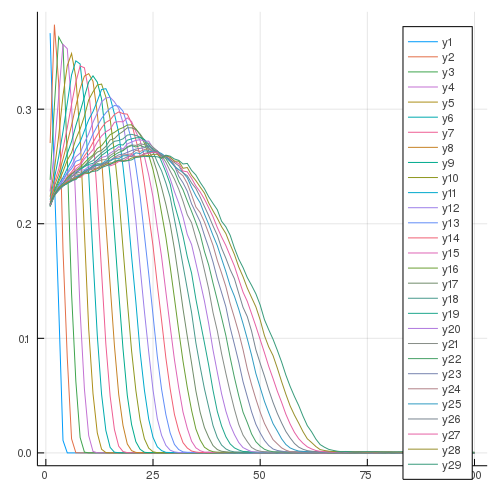

In [144]:
p = plot()
for e in energy[2:end]
    p = plot!(collect(range(1, stop=100)), [K_cont(e - 0.25 , y_) for y_ in collect(range(1, stop=100))])
#     println(e)
end
display(p)



# plot(collect(range(1, stop=100)), [K_cont(5.234, y_) for y_ in collect(range(1, stop=100))])
# plot!(collect(range(1, stop=100)), [K_another(100, y_) for y_ in collect(range(1, stop=100))])

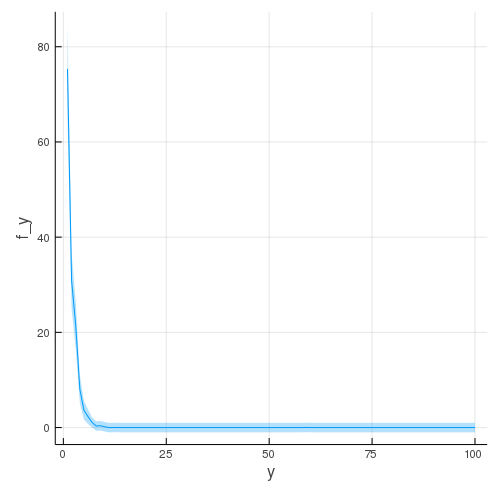

In [145]:
sig = 0.01*f_y + [max(sqrt(i), 1) for i in f_y]
f = f_y;
plot(f_y, ribbon=sig, fillalpha=0.3, xlabel="y", ylabel="f_y", label="")#, dpi=400,
#     xtickfontsize=18,ytickfontsize=18, legendfontsize=18, guidefont=font(18), color = :blue)
# savefig("f_y_cont.png")

In [154]:
basis = CubicSplineBasis(0.5, 15, 60, (nothing, "dirichlet"));
Omega = omega(basis);
model = GaussErrorUnfolder(basis, [Omega], "User", alphas=[0.1]);#alphas=[0.1440379000137214]);

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:107
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140
┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:161


In [155]:
@time result = solve(model, K_cont, f, sig, collect(range(1, stop=100)));
# @time result_another = solve(model, K_another, f, sig, collect(range(1, stop=100)));

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44


 43.436670 seconds (1.05 G allocations: 27.442 GiB, 33.71% gc time)


┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:105
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:202


In [156]:
# plot(result["coeff"] - result_another["coeff"])

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


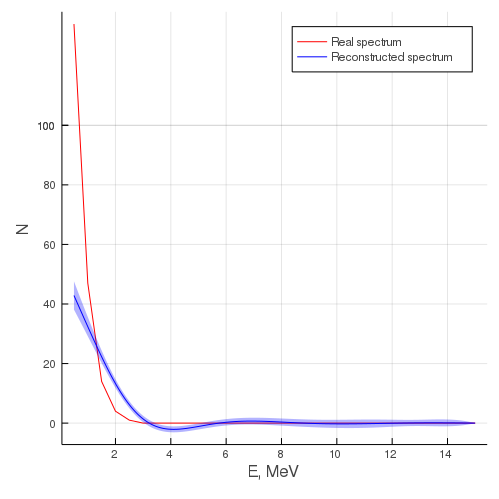

In [157]:
x = collect(range(0.5, 14.9999, length=500))
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x) / 2
phi_reconstructed_errors = phivec.error_function.(x)

plot(energy, arr_spectrum_real, label="Real spectrum", color=:red)
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="E, MeV", ylabel="N", color = :blue)
#     xtickfontsize=12,ytickfontsize=12, legendfontsize=12, guidefont=font(12), dpi=200)
# # savefig("reconstructed_cont.png")

In [150]:
println(arr_spectrum_real)

[134, 47, 14, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [151]:
# arr_rec = phivec.phi_function.(energy)
# for_plot = [abs(arr_rec[i]-arr_spectrum_real[i])/arr_spectrum_real[i] for i in range(1, stop=length(arr_rec))]
# print(mean(for_plot))
# plot(for_plot, linestyle=:dot)

In [152]:
# x = collect(range(1, 150, length=500))
# phivec_another = PhiVec(result_another, basis)

# phi_reconstructed_another = phivec_another.phi_function.(x)
# phi_reconstructed_errors_another = phivec_another.error_function.(x)

# plot(collect(range(1, stop=150)), arr_spectrum_real, label="Real spectrum", color=:red)
# plot!(x, phi_reconstructed_another, ribbon=phi_reconstructed_errors_another, fillalpha=0.3,
#     label="Reconstructed spectrum", xlabel="E, MeV", ylabel="N", color = :blue,)
# #     xtickfontsize=12,ytickfontsize=12, legendfontsize=12, guidefont=font(12),  dpi=200)
# # savefig("reconstructed_cont.png")

In [153]:
# arr_rec_another = phivec_another.phi_function.(energy)
# for_plot_another = [abs(arr_rec_another[i]-arr_spectrum_real[i])/arr_spectrum_real[i] for i in range(1, stop=length(arr_rec))]
# print(mean(for_plot_another))
# plot(for_plot_another, linestyle=:dot)